In [3]:
import requests 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import empyrical as ep

plt.style.use('default')
plt.rcParams["figure.figsize"] = (8,5.5)

In [4]:
API_key = "385ZUF7ZLAH3LO8V"
tickers = ['AAPL', 'JNJ', 'MSFT', 'PG', 'GOOGL', 'VZ', 'AMZN', 'KO', 'T', 'UNH', 'HD', 'MA', 'COST', 'NVDA', 'XOM', 'NFLX', 'BAC', 'CVS', 'LOW', 'JPM']


def get_daily_data(ticker, API_key):
    # Gets the data and stores it in a dict
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=' + str(ticker) + '&outputsize=full&apikey=' + API_key
    r = requests.get(url)
    data = r.json()
    return data

def get_daily_rf_data(API_key):
    # Gets the data and stores it in a dict
    url = 'https://www.alphavantage.co/query?function=FEDERAL_FUNDS_RATE&interval=daily&apikey=&outputsize=full&apikey=' + API_key
    r = requests.get(url)
    data = r.json()
    return data

def vwap(prices, volumes, window):
    """
    prices: A list of prices.
    volumes: A list of volumes corresponding to the prices.
    window: The time window for which to calculate the VWAP values.
    Returns a list of VWAP values for the given time window.
    """
    vwap_values = []
    total_value = 0
    total_volume = 0
    
    for i in range(len(prices)):
        total_value += prices[i] * volumes[i]
        total_volume += volumes[i]
        if i >= window:
            total_value -= prices[i-window] * volumes[i-window]
            total_volume -= volumes[i-window]
        vwap = total_value / total_volume
        vwap_values.append(vwap)
    
    return vwap_values


In [5]:
start_date = '2014-01-01'
end_date = '2019-12-31'
ticker = "SPY"
#ticker = "M"


data = pd.DataFrame(get_daily_data(ticker, API_key)['Time Series (Daily)'])
data = data.transpose()
data.columns = ['Open', 'High', 'Low', 'Close', 'Adjusted Close', 'Volume', 'Dividend Amount', 'Split Coefficient']
data = data.loc[(data.index >= start_date)&(data.index < end_date)]
data.index = pd.to_datetime(data.index)
data = data.astype("float")

In [6]:
rf1 = pd.DataFrame(get_daily_rf_data(API_key))
rf = pd.DataFrame(rf1["data"].to_list())
rf = rf.loc[(rf['date'] >= start_date)&(rf['date'] < end_date)] 
rf['value'] = rf['value'].astype('float')
rf['date'] = pd.to_datetime(rf['date']).dt.date
rf = rf.set_index(['date'])

<h2>Part 1 - Time Series Prep</h2>

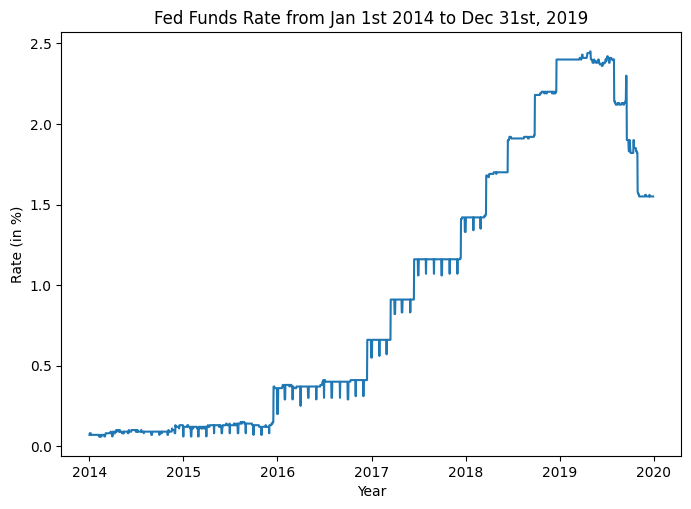

In [7]:
plt.plot(rf['value'])
plt.title('Fed Funds Rate from Jan 1st 2014 to Dec 31st, 2019')
plt.xlabel('Year')
plt.ylabel('Rate (in %)')
plt.show()

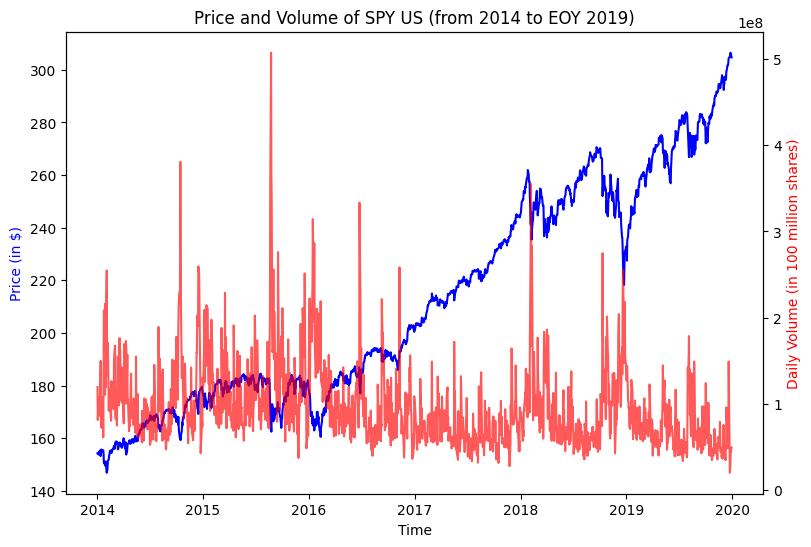

In [76]:
fig, ax1 = plt.subplots()
color = 'blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Price (in $)',color=color)
ax1.plot(data.index, data["Adjusted Close"], color=color)
ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('Daily Volume (in 100 million shares)', color=color)
ax2.plot(data.index, data["Volume"], color=color, alpha=0.65)
ax2.tick_params(axis='y')
plt.title(f'Price and Volume of {ticker} US (from 2014 to EOY 2019)')
plt.show()

C:\Users\leopa\AppData\Local\Temp\ipykernel_10204\1048507125.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  riskfree.append(rf.loc[((rf.index == i))]["value"][0])


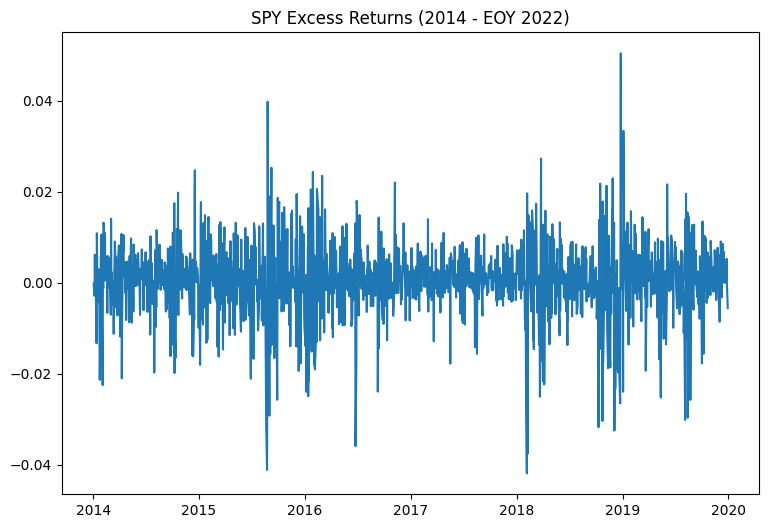

In [77]:
riskfree = []
for i in data.index:
    riskfree.append(rf.loc[((rf.index == i))]["value"][0])
    
if len(riskfree) == len(data):
    data["Risk Free Rate"] = riskfree 
else:
    print(len(riskfree))
    len(data)

data["Risk Free Rate"] = 1/25200*data["Risk Free Rate"]
data['return'] = (data["Adjusted Close"]-data["Adjusted Close"].shift(-1))/data["Adjusted Close"].shift(-1)
data['SPY Excess returns'] = data['return'] - data['Risk Free Rate'] 
plt.plot(data['SPY Excess returns'])
plt.savefig("excessr.png")
plt.title(f"{ticker} Excess Returns (2014 - EOY 2022)")
plt.show()

<h2>Part 2 - Trading Strategies</h2>

<h3>Trading Strategy 1: Simple VWAP trading rule</h3>

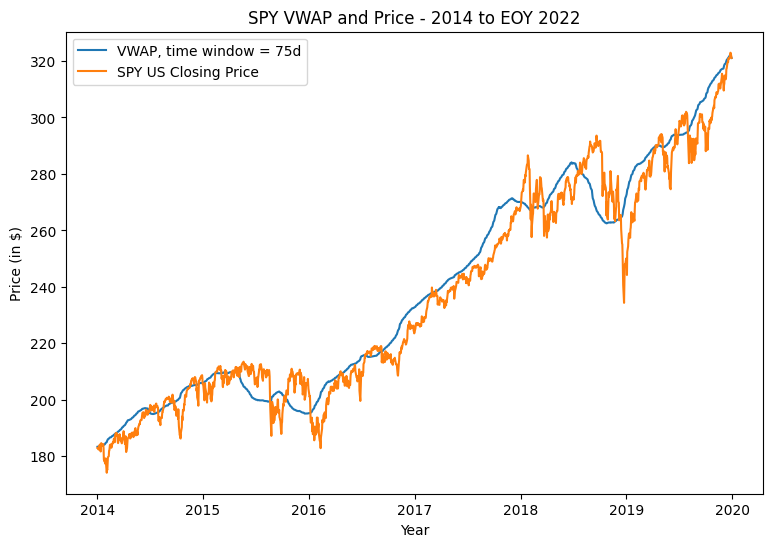

In [79]:
VWAP_window = 75
data["VWAP"] = vwap(data["Close"], data["Volume"], VWAP_window)

plt.plot(data["VWAP"], label="VWAP, time window = 75d")
plt.plot(data["Close"], label="SPY US Closing Price")
plt.title(f"{ticker} VWAP and Price - 2014 to EOY 2022")
plt.xlabel("Year")
plt.legend(loc="upper left")
plt.ylabel("Price (in $)")
plt.show()

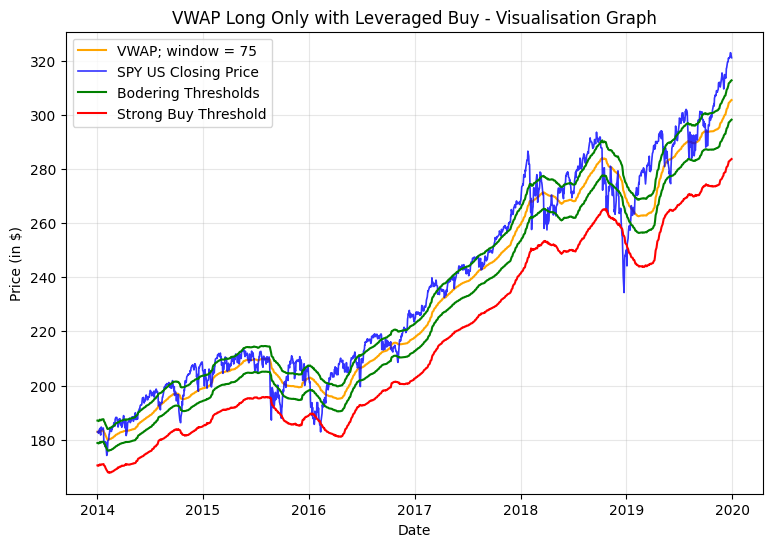

In [37]:
alpha = 0.0003

t_plus = data["VWAP"] + alpha*data["Open"]*VWAP_window
t_minus = data["VWAP"] - alpha*data["Open"]*VWAP_window
t_minus_2 = data["VWAP"] - 3*alpha*data["Open"]*VWAP_window

plt.style.use('default')
plt.rcParams["figure.figsize"] = (9,6)

label = "VWAP; window = " + str(VWAP_window)
plt.plot(data["VWAP"], label=label, color="orange")
plt.plot(data["Close"], label="SPY US Closing Price", color="blue",alpha=0.8, linewidth=1.2)
plt.plot(t_minus, label="Bodering Thresholds", color="green")
plt.plot(t_minus_2, label="Strong Buy Threshold", color="red")
plt.plot(t_plus, color="green")
plt.grid(alpha=0.3)
plt.legend(loc="upper left")
plt.title("VWAP Long Only with Leveraged Buy - Visualisation Graph")
plt.ylabel("Price (in $)")
plt.xlabel("Date")
plt.show()

One thing to take into colsideration is that we have access to the previous day VWAP value on close, So we can't trade on the price close, we have to trade on the next day open whenever we have the information.

In [10]:
portfolio = {
            }

max_exposure = 3 # max leverage for opening trades
margin_call_max_lev = 5 

leverage, exposure, leverage_financing_dollar, total_porfolio_value = [], [], [], []

def buy(quantity, price):
    """ 
    Updates portfolio and checks for availability
    """
    portfolio["cash"] -= price*quantity
    portfolio["SPY"] += quantity
    print(f"Bought {quantity} {ticker} at ${price}")    
    return 0

def sell(quantity, price):
    """ 
    Updates portfolio and checks for availability
    """
    portfolio["cash"] += price*quantity
    portfolio["SPY"] -= quantity
    print(f"Sold {quantity} {ticker} at ${price}")    
    return 0

def value_portfolio(last_close):
    global portfolio
    return portfolio["cash"]+portfolio["SPY"]*last_close

2014-01-24 00:00:00
Bought 1117 SPY at $179.06

Strong Buy:
2014-10-13 00:00:00
Bought 2234 SPY at $188.42

2015-05-14 00:00:00
Sold 3351 SPY at $212.44

2015-08-24 00:00:00
Bought 1534 SPY at $195.43

Strong Buy:
2015-09-28 00:00:00
Bought 3068 SPY at $188.27

2015-10-22 00:00:00
Sold 4602 SPY at $207.25

2016-01-13 00:00:00
Bought 1945 SPY at $189.550003

Strong Buy:
2016-06-27 00:00:00
Bought 3890 SPY at $201.479996

2018-01-11 00:00:00
Sold 5835 SPY at $276.42

2018-02-08 00:00:00
Bought 3196 SPY at $260.8

2018-02-23 00:00:00
Sold 3196 SPY at $275.93

2018-03-23 00:00:00
Bought 3384 SPY at $262.13

2018-08-17 00:00:00
Sold 3384 SPY at $285.57

2018-12-17 00:00:00
Bought 3776 SPY at $257.2

Strong Buy:
2018-12-20 00:00:00
Bought 7552 SPY at $246.74

2019-07-15 00:00:00
Sold 11328 SPY at $300.65

2019-08-05 00:00:00
Bought 5361 SPY at $285.91

Strong Buy:
2019-10-08 00:00:00
Bought 10722 SPY at $290.75

{'cash': -3132346.91622975, 'money_market': 998928.0098941753, 'SPY': 16083, 'po

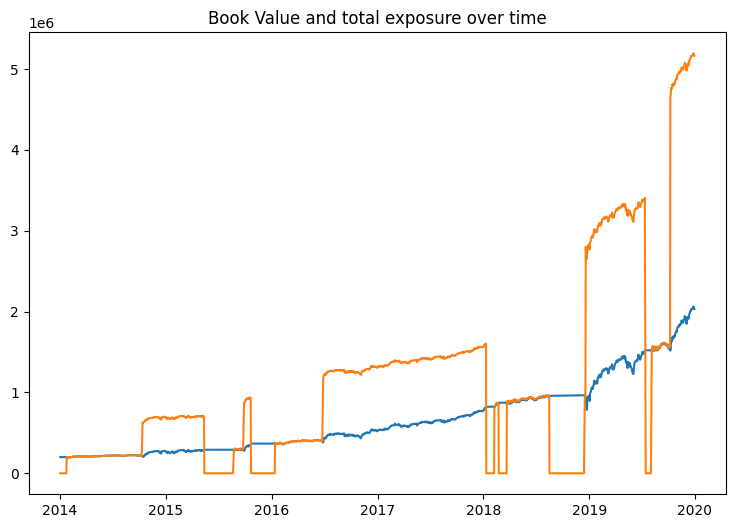

In [11]:
# Portfolio initiation
# Long only strategy

portfolio = {
            "cash": 200000, # Tracks debt owed to Prime Broker, is impacted by leverage financing and by interests earned in money market
            "money_market": 200000, # cannot be negative or margin called
            "SPY": 0, # asset owned
            "posted_margin": 0
            }

turnover_dollar, exposure_units, turnover_units, exposure, leverage_financing_dollar, total_porfolio_value, cash, pnl, pnl_dollar, money_market, posted_margin, accumulated_interests  = [], [], [], [], [], [], [], [], [], [], [], []
can_strong_buy = True
can_buy = True

degross_ratio = 0.80 # Threshold at which it is needed to degross
sell_to_in_degross = 0.60 # Where to aim degrossing the book

data = data.sort_index()
t_minus = t_minus.sort_index()
t_minus_2 = t_minus_2.sort_index()
t_plus = t_plus.sort_index()

for i in range(len(data)):
    if data["Close"][i] > t_plus[i] and portfolio['SPY'] != 0:
        print(data.index[i])
        sell(portfolio['SPY'], data["Open"][i+1]) # Sell at next day open 
        print("")
        can_strong_buy = True
        can_buy = True
    
    elif data["Close"][i] < t_minus[i] and portfolio['SPY'] == 0 and can_buy:
        amount = int((portfolio['cash']/data["Close"][i])-1)
        print(data.index[i])
        buy(amount, data["Open"][i+1]) # Buy at next day open
        print("")
        
    elif data["Close"][i] < t_minus_2[i] and not(data["Close"][i-1] < t_minus_2[i]) and can_strong_buy: # Strong  Buys
        amount = int((max_exposure-1) * portfolio['SPY']) # Max leverage buy
        print("Strong Buy:")
        print(data.index[i])
        buy(amount, data["Open"][i+1])
        print("")
        can_strong_buy = False
    
    total_porfolio_value.append(value_portfolio(data["Close"][i]))
    exposure.append(portfolio["SPY"]*data["Close"][i])
    exposure_units.append(portfolio["SPY"])
    leverage.append(portfolio["SPY"]*data["Close"][i]/value_portfolio(data["Close"][i]))
    
    if portfolio["cash"] < 0: # If im short cash, I pay interests on financing. 
        portfolio["cash"] = portfolio["cash"] * (1 + data["Risk Free Rate"][i])
        leverage_financing_dollar.append(portfolio["cash"]*(data["Risk Free Rate"][i]))
    else:
        leverage_financing_dollar.append(0)
    if i == 0:
        pnl.append(0)
        turnover_dollar.append(0)
        turnover_units.append(0)
        pnl_dollar.append(0)
    else:
        pnl.append((total_porfolio_value[i] - total_porfolio_value[i-1])/total_porfolio_value[i-1])
        pnl_dollar.append(total_porfolio_value[i] - total_porfolio_value[i-1])
        turnover_dollar.append(exposure[i]-exposure[i-1])
        turnover_units.append((exposure_units[i]-exposure_units[i-1]))
    # Money Market/ Value:
    
    portfolio["posted_margin"] = exposure[i] / margin_call_max_lev
    posted_margin.append(portfolio["posted_margin"])
    
    portfolio["money_market"] = total_porfolio_value[i] - posted_margin[i]
    money_market.append(portfolio["money_market"])
    
    # Money market account value's impact on cash:
    
    accumulated_interests.append(portfolio["money_market"]*(data["Risk Free Rate"][i]))
    portfolio["cash"] = portfolio["cash"] + (portfolio["money_market"]*(data["Risk Free Rate"][i]))
    cash.append(portfolio["cash"])
    ratio = portfolio["posted_margin"] / total_porfolio_value[i]
    
    
    if ratio > degross_ratio:
        degross_amount = int((exposure[i]-(sell_to_in_degross*total_porfolio_value[i]*margin_call_max_lev))/data["Close"][i])-int(1)
        can_buy = False
        print("!DEGROSS ALERT!")
        print(data.index[i])
        sell(degross_amount, data["Open"][i+1])
        print("")
        

    
print(portfolio)

# check annualized returns

returns_strat1 = ((total_porfolio_value[-1]-total_porfolio_value[0])/total_porfolio_value[0])
print(f"Returns of strat over 6 years is: {round(100*returns_strat1, 2)}% or {round((np.power(1+returns_strat1, 1/6)-1)*100, 2)}% annualized returns\n")
print(f"Sum of leverage financing over trading period: ${-round(sum(leverage_financing_dollar), 2)}")
print(f"Sum of interests earned over trading period: ${round(sum(accumulated_interests), 2)}")
print(f"Turnover of strategy: ${round(total_porfolio_value[-1]-total_porfolio_value[0], 2)} or {int(round(total_porfolio_value[-1]-total_porfolio_value[0], 2)/data['Close'][-1])} units of {ticker} (final close price)")



plt.plot(data.index, total_porfolio_value)
plt.plot(data.index, exposure)
plt.title("Book Value and total exposure over time")
plt.show()


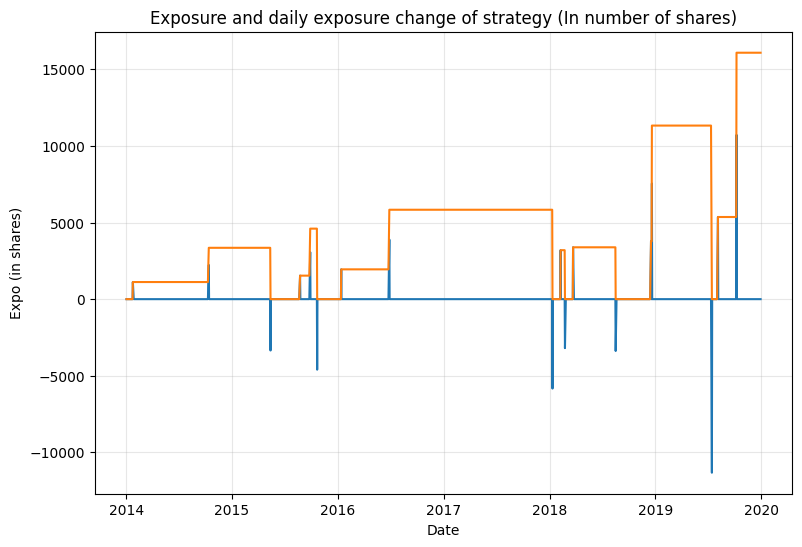

In [12]:
turnover_units = pd.DataFrame(turnover_units, index=data.index)
exposure_units = pd.DataFrame(exposure_units, index=data.index)

plt.plot(turnover_units, label="Daily change in exposure (in $)")
plt.plot(exposure_units, label="Exposure")
plt.xlabel("Date")
plt.ylabel("Expo (in shares)")
plt.title("Exposure and daily exposure change of strategy (In number of shares)")
plt.grid(alpha=0.3)
plt.show()


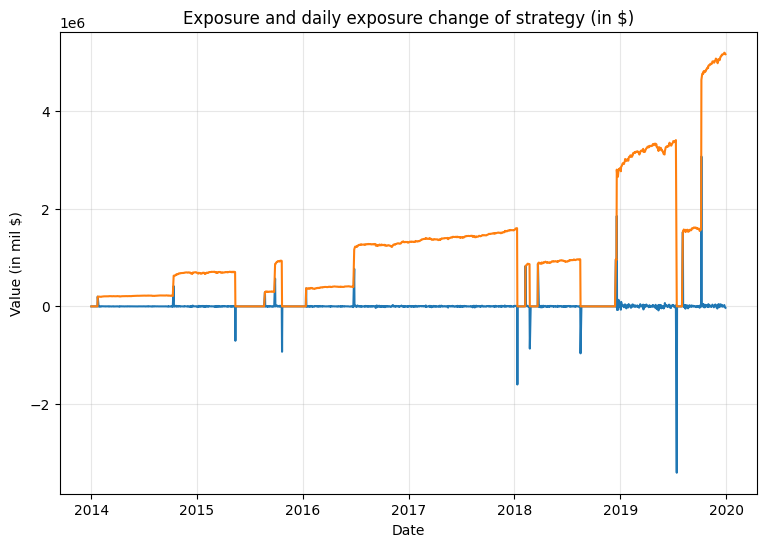

In [13]:
turnover_dollar = pd.DataFrame(turnover_dollar, index=data.index)
exposure = pd.DataFrame(exposure, index=data.index)

plt.plot(turnover_dollar, label="Daily change in exposure (in $)")
plt.plot(exposure, label="Exposure")
plt.xlabel("Date")
plt.ylabel("Value (in mil $)")
plt.title("Exposure and daily exposure change of strategy (in $)")
plt.grid(alpha=0.3)
plt.show()


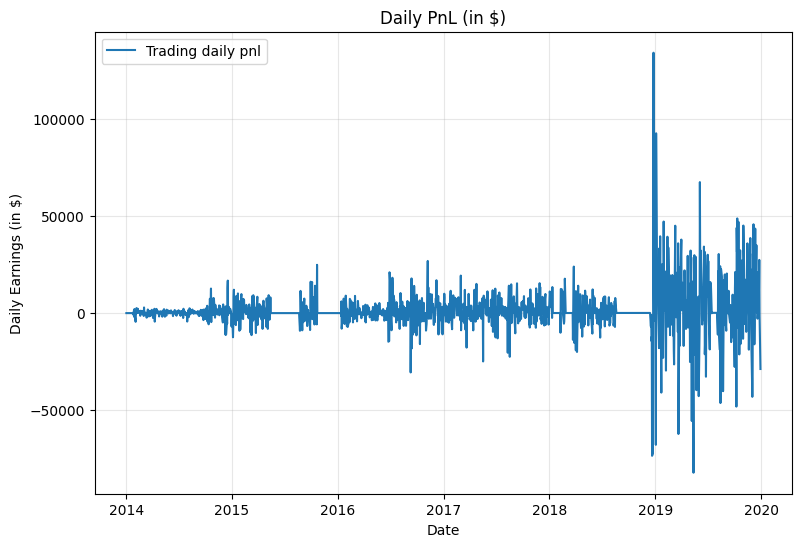

In [14]:
plt.plot(data.index, pnl_dollar, label= "Trading daily pnl" )
plt.title("Daily PnL (in $)")
plt.legend(loc="best")
plt.xlabel("Date")
plt.ylabel("Daily Earnings (in $)")
plt.grid(alpha=0.3)
plt.show()


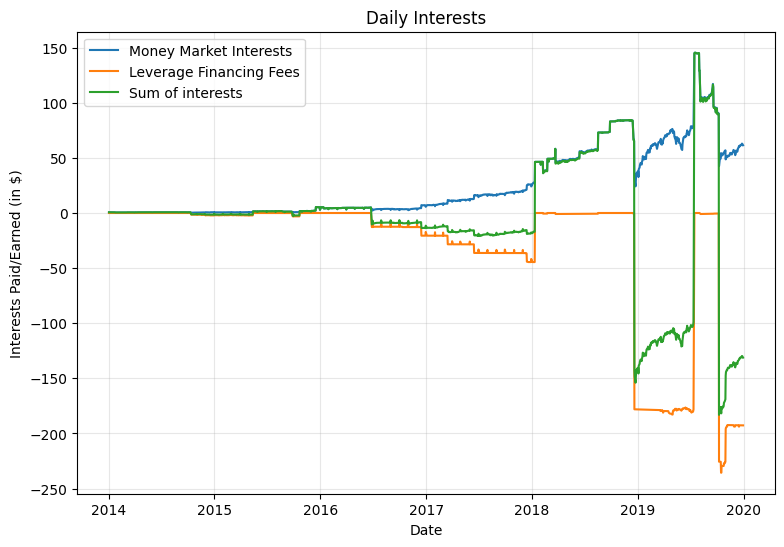

In [15]:
accumulated_interests = pd.DataFrame(accumulated_interests, index=data.index)
leverage_financing_dollar = pd.DataFrame(leverage_financing_dollar, index=data.index)

plt.plot(data.index, accumulated_interests, label="Money Market Interests")
plt.title("Daily Interests")
plt.plot(data.index,leverage_financing_dollar, label="Leverage Financing Fees")
plt.plot(data.index,leverage_financing_dollar+accumulated_interests, label="Sum of interests")
plt.legend(loc="best")
plt.xlabel("Date")
plt.ylabel("Interests Paid/Earned (in $)")
plt.grid(alpha=0.3)
plt.show()

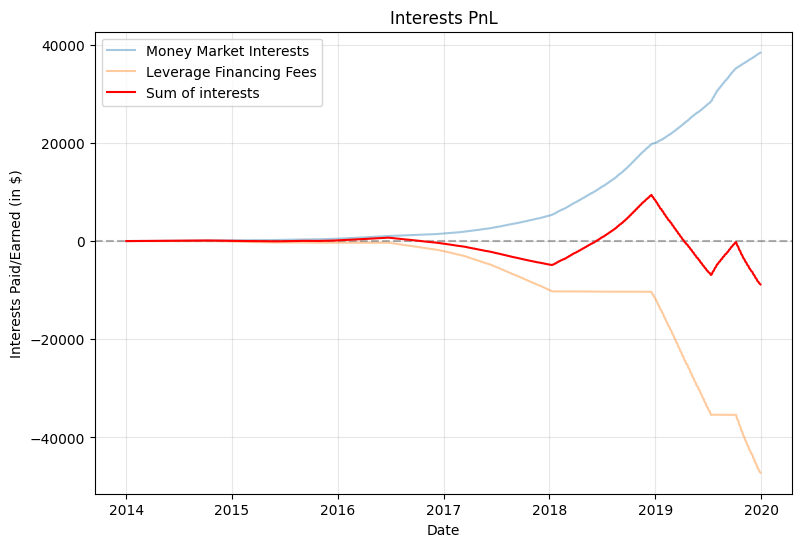

In [16]:
acc_int = accumulated_interests.cumsum()
lev_finn = leverage_financing_dollar.cumsum()

plt.plot(acc_int, label="Money Market Interests", alpha=0.4)
plt.title("Interests PnL")
plt.axhline(0, linestyle="--", color="0", alpha=0.3)
plt.plot(lev_finn, label="Leverage Financing Fees", alpha=0.4)
plt.plot(lev_finn+acc_int, label="Sum of interests", color="r")
plt.legend(loc="best")
plt.xlabel("Date")
plt.ylabel("Interests Paid/Earned (in $)")
plt.grid(alpha=0.3)
plt.show()

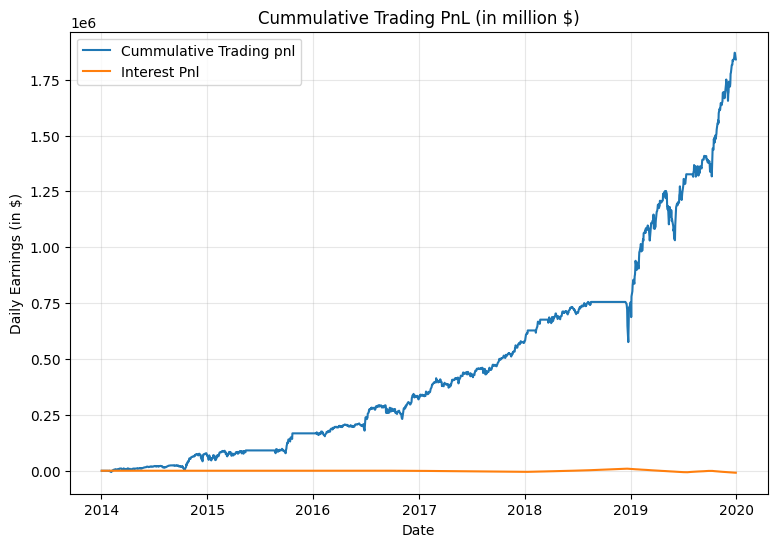

In [17]:
pnl_dollar = pd.DataFrame(pnl_dollar, index=data.index)

plt.plot(pnl_dollar.cumsum()-(lev_finn+acc_int), label= "Cummulative Trading pnl" )
plt.plot((lev_finn+acc_int), label= "Interest Pnl" )
plt.title("Cummulative Trading PnL (in million $)")
plt.legend(loc="best")
plt.xlabel("Date")
plt.ylabel("Daily Earnings (in $)")
plt.grid(alpha=0.3)
plt.show()

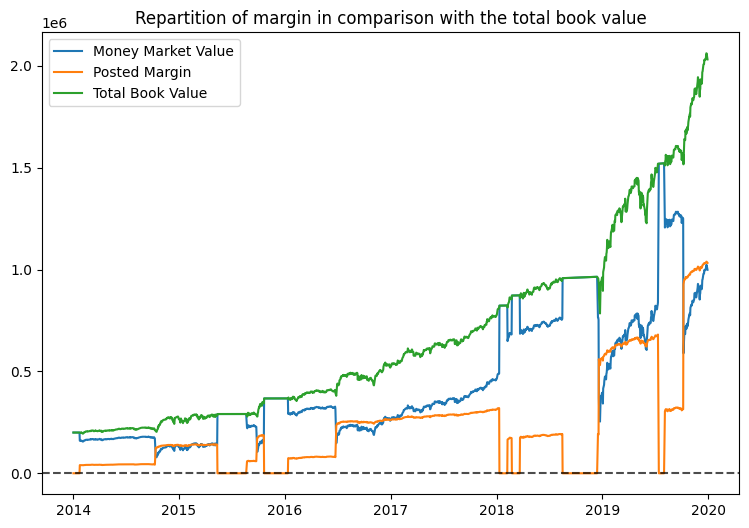

In [18]:
plt.plot(data.index, money_market, label="Money Market Value")
plt.plot(data.index, posted_margin, label="Posted Margin")
plt.plot(data.index, total_porfolio_value, label="Total Book Value")
plt.title(f"Repartition of margin in comparison with the total book value")
plt.axhline(0, linestyle="--", color="0", alpha=0.7)
plt.legend(loc="upper left")
plt.savefig(f"book repartition {ticker}.png", dpi=150)
plt.show()

The maximum value of posted margin to book ratio was: 67.67%



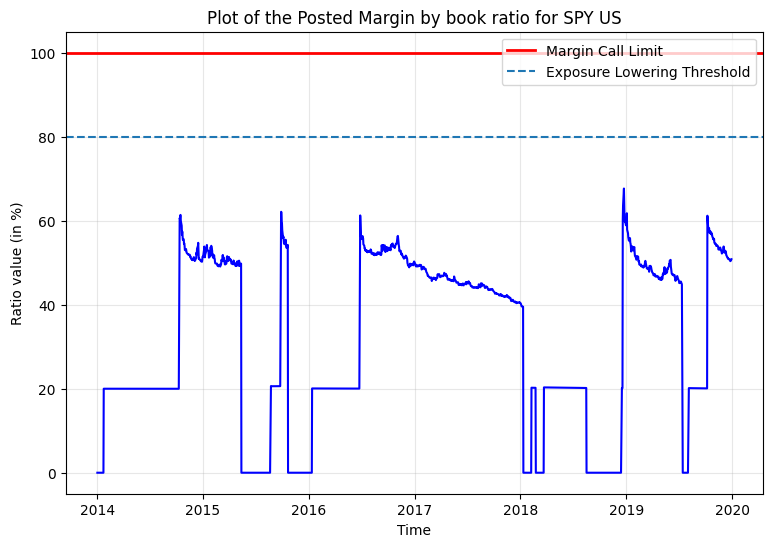

In [19]:
total_portfolio_value = pd.DataFrame(total_porfolio_value, index=data.index)
posted_margin = pd.DataFrame(posted_margin, index=data.index)

margin_req_by_book_value = 100*posted_margin/total_portfolio_value

print(f"The maximum value of posted margin to book ratio was: {round(margin_req_by_book_value.max()[0], 2)}%")
print("")

plt.plot(margin_req_by_book_value, color="b")
plt.axhline(100, label="Margin Call Limit", color="red", linewidth="2")
plt.axhline(100*degross_ratio, label="Exposure Lowering Threshold", linestyle="--")
plt.legend(loc="best")
plt.xlabel("Time")
plt.title(f"Plot of the Posted Margin by book ratio for {ticker} US")
plt.ylabel("Ratio value (in %)")
plt.savefig("VWAP strategy1.png", dpi=150)
plt.grid(alpha=0.3)
plt.show()

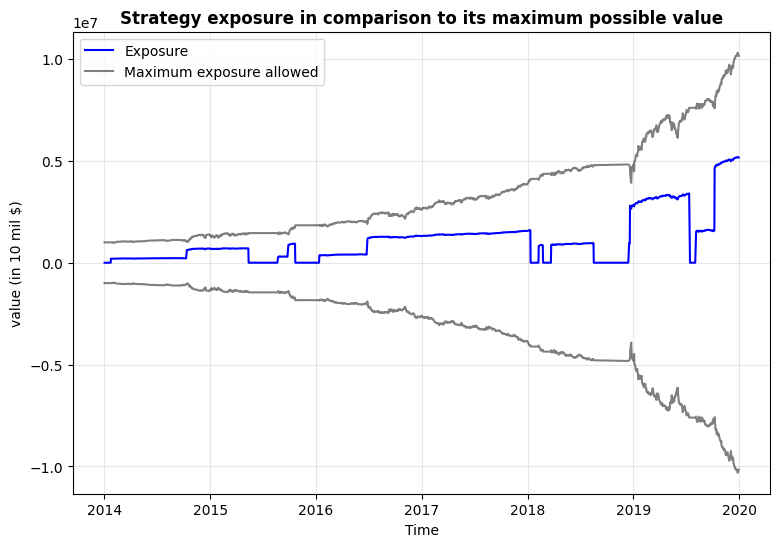

In [22]:
exposure = pd.DataFrame(exposure, index=data.index)
plt.plot(exposure, color="Blue", label = "Exposure")
plt.plot(-5*total_portfolio_value, color="0", alpha=0.5, label="Maximum exposure allowed")
plt.plot(5*total_portfolio_value, color="0", alpha=0.5)
plt.legend()
plt.xlabel("Time")
plt.ylabel("value (in 10 mil $)")
plt.grid(alpha=0.3)
plt.title("Strategy exposure in comparison to its maximum possible value", fontweight="bold")
plt.show()

In [23]:
# sharpe, calmar, sortino and max drawdown calculation

excess_return = []
for i in range(len(pnl)):
    excess_return.append(pnl[i]-data["Risk Free Rate"][i])
excess_return = pd.DataFrame(excess_return, index=data.index)

sharpe_ratio = ep.sharpe_ratio(excess_return)[0]
#timeseries.sharpe_ratio(excess_return)[0]
max_drawdown = 100*excess_return.min()[0]
sortino_ratio = ep.sortino_ratio(excess_return)[0]
calmar_ratio = ((excess_return.mean()[0]+1)**(252)-1)/(-max_drawdown/100)  # EP function crashes 

print(f"Sharpe: {round(sharpe_ratio,2)}") # Limitation: calculated using daily data
print(f"Max Drawdown: {round(max_drawdown, 2)}%")
print(f"Sortino Ratio: {round(sortino_ratio, 2)}")
print(f"Calmar Ratio: {round(calmar_ratio, 2)}")


Sharpe: 1.82
Max Drawdown: -8.44%
Sortino Ratio: 3.02
Calmar Ratio: 5.86


In [24]:
rolling_volatility = data["return"].rolling(window=90).std()
to_calc_max_dd = pd.Series(total_portfolio_value[0])
max_data = to_calc_max_dd.rolling(window=30, min_periods=1).max()
drawdown = to_calc_max_dd/max_data - 1
monthly_drawdown = drawdown.rolling(window=1, min_periods=1).min()

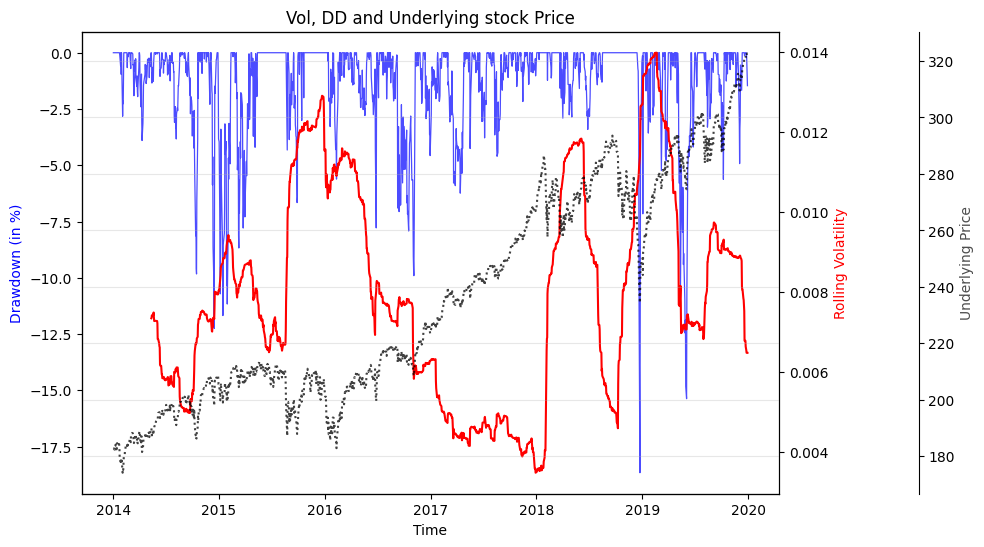

In [29]:

# Create a figure with two y-axes
fig, ax1 = plt.subplots()
color = 'blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Drawdown (in %)', color=color)
ax1.plot(100*monthly_drawdown, color=color, linewidth=0.9, alpha=0.7)

ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('Rolling Volatility', color=color)
ax2.plot(rolling_volatility, color=color, label="90d Volatility")
ax2.tick_params(axis='y')

# Create a third y-axis for the daily pnl
ax3 = ax1.twinx()

# Plot the daily pnl on ax3
color = '0'
ax3.plot(data.index, data["Close"], color=color, linestyle=":", label="Cumulative PnL", alpha=0.75)
ax3.set_ylabel('Underlying Price', color=color, alpha=0.7)
ax3.spines['right'].set_position(('axes', 1.2))

plt.grid(alpha=0.3)
plt.title("Vol, DD and Underlying stock Price")
plt.savefig("Drawdown chart SPY Long only.png", dpi=150)
plt.show()

<h3>Trading Strategy 2: Leverage Free VWAP strat</h3>

In [61]:
portfolio = {
            }

max_exposure = 3 # max leverage for opening trades
margin_call_max_lev = 5 


def buy(quantity, price):
    """ 
    Updates portfolio and checks for availability
    """
    portfolio["cash"] -= price*quantity
    portfolio["SPY"] += quantity
    print(f"Bought {quantity} {ticker} at ${price}")    
    return 0

def sell(quantity, price):
    """ 
    Updates portfolio and checks for availability
    """
    portfolio["cash"] += price*quantity
    portfolio["SPY"] -= quantity
    print(f"Sold {quantity} {ticker} at ${price}")    
    return 0

def value_portfolio(last_close):
    global portfolio
    return portfolio["cash"]+portfolio["SPY"]*last_close

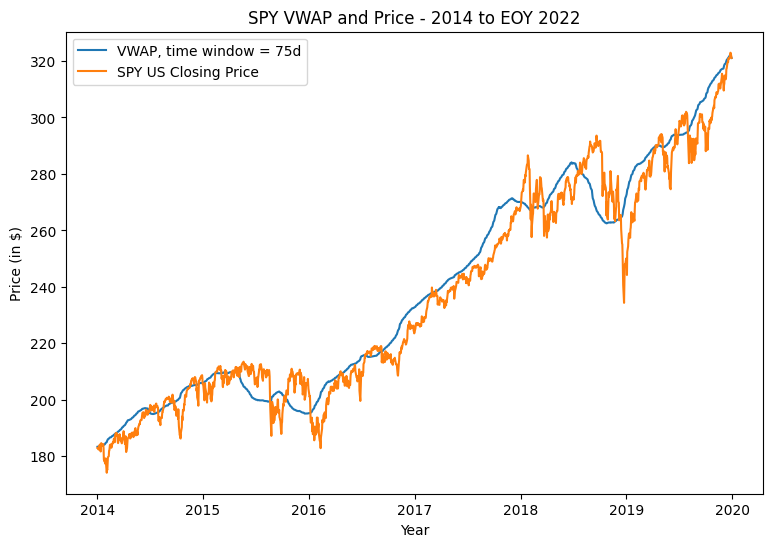

In [62]:
VWAP_window = 75
data["VWAP"] = vwap(data["Close"], data["Volume"], VWAP_window)

plt.plot(data["VWAP"], label="VWAP, time window = 75d")
plt.plot(data["Close"], label="SPY US Closing Price")
plt.title(f"{ticker} VWAP and Price - 2014 to EOY 2022")
plt.xlabel("Year")
plt.legend(loc="upper left")
plt.ylabel("Price (in $)")
plt.show()

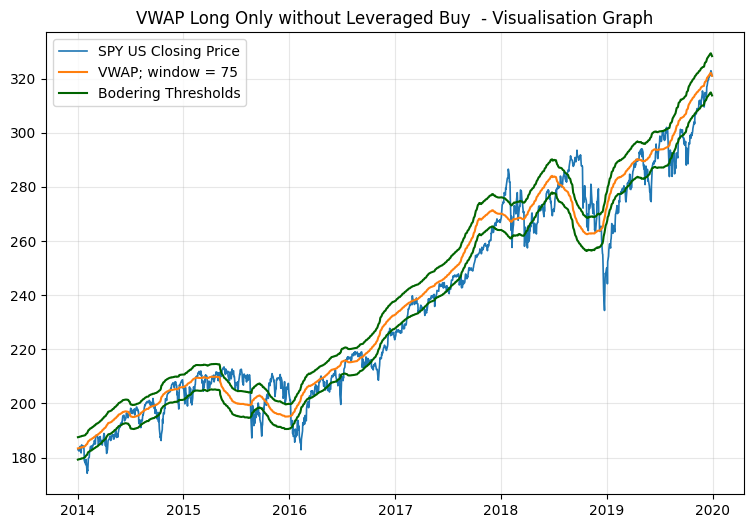

In [63]:
alpha = 0.0003

t_plus = data["VWAP"] + alpha*data["Open"]*VWAP_window
t_minus = data["VWAP"] - alpha*data["Open"]*VWAP_window

plt.style.use('default')
plt.rcParams["figure.figsize"] = (9,6)

label = "VWAP; window = " + str(VWAP_window)
plt.plot(data["Close"], label="SPY US Closing Price", linewidth=1.2)
plt.plot(data["VWAP"], label=label)
plt.plot(t_minus, color="darkgreen", label="Bodering Thresholds")
plt.plot(t_plus, color="darkgreen")
plt.legend(loc="upper left")
plt.title("VWAP Long Only without Leveraged Buy  - Visualisation Graph")
plt.grid(which='major', alpha=0.3)
plt.show()

2014-01-24 00:00:00
Bought 1115 SPY at $179.06

2015-05-14 00:00:00
Sold 1115 SPY at $212.44

2015-08-24 00:00:00
Bought 1214 SPY at $195.43

2015-10-22 00:00:00
Sold 1214 SPY at $207.25

2016-01-13 00:00:00
Bought 1328 SPY at $189.550003

2018-01-11 00:00:00
Sold 1328 SPY at $276.42

2018-02-08 00:00:00
Bought 1423 SPY at $260.8

2018-02-23 00:00:00
Sold 1423 SPY at $275.93

2018-03-23 00:00:00
Bought 1500 SPY at $262.13

2018-08-17 00:00:00
Sold 1500 SPY at $285.57

2018-12-17 00:00:00
Bought 1686 SPY at $257.2

2019-07-15 00:00:00
Sold 1686 SPY at $300.65

2019-08-05 00:00:00
Bought 1794 SPY at $285.91

{'cash': 3559.0027701936583, 'money_market': 464344.45790075924, 'SPY': 1794, 'posted_margin': 115203.504}
1.8977398095037963
Returns of strat over 6 years is: 189.77% or 19.4% annualized returns
Sum of leverage financing over trading period: $0
Sum of interests earned over trading period: $19603.32
Turnover of strategy: $379547.96 or 1182 units of SPY (final close price)


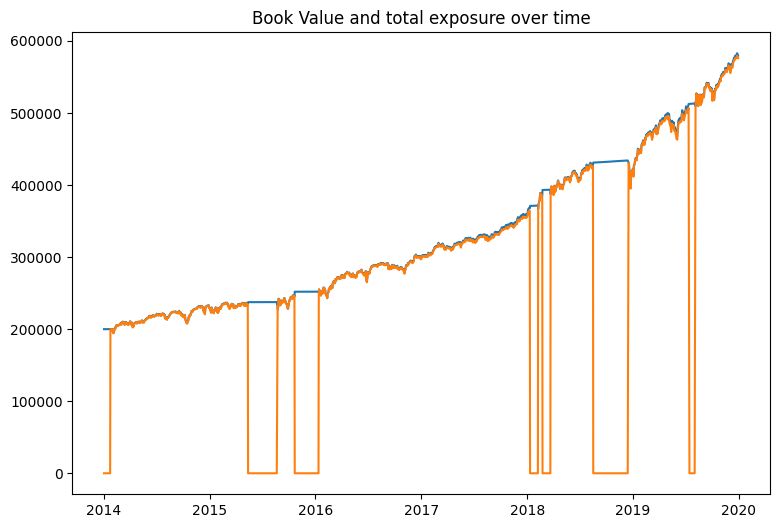

In [64]:
# Portfolio initiation
# Long only strategy

portfolio = {
            "cash": 200000, # Tracks debt owed to Prime Broker, is impacted by leverage financing and by interests earned in money market
            "money_market": 200000, # cannot be negative or margin called
            "SPY": 0, # asset owned
            "posted_margin": 0
            }

turnover_dollar, exposure_units, turnover_units, cash_pnl, exposure, leverage_financing_dollar, total_porfolio_value, cash, pnl, money_market, posted_margin, accumulated_interests  = [], [], [], [], [], [], [], [], [], [], [], []

can_strong_buy = False

can_buy = True


degross_ratio = 0.80 # Threshold at which it is needed to degross
sell_to_in_degross = 0.60 # Where to aim degrossing the book

data = data.sort_index()
t_minus = t_minus.sort_index()
t_minus_2 = t_minus_2.sort_index()
t_plus = t_plus.sort_index()

for i in range(len(data)):
    if data["Close"][i] > t_plus[i] and portfolio['SPY'] != 0:
        print(data.index[i])
        sell(portfolio['SPY'], data["Open"][i+1]) # Sell at next day open 
        print("")
        can_buy = True
    
    elif data["Close"][i] < t_minus[i] and portfolio['SPY'] == 0 and can_buy:
        amount = int((portfolio['cash']/data["Open"][i+1])-1)
        print(data.index[i])
        buy(amount, data["Open"][i+1]) # Buy at next day open
        print("")
        
    elif data["Close"][i] < t_minus_2[i] and not(data["Close"][i-1] < t_minus_2[i]) and can_strong_buy: # Strong  Buys
        amount = int((max_exposure-1) * portfolio['SPY']) # Max leverage buy
        print("Strong Buy:")
        print(data.index[i])
        buy(amount, data["Open"][i+1])
        print("")
        can_strong_buy = False
    
    total_porfolio_value.append(value_portfolio(data["Close"][i]))
    exposure.append(portfolio["SPY"]*data["Close"][i])
    exposure_units.append(portfolio["SPY"])
    
    if portfolio["cash"] < 0: # If im short cash, I pay interests on financing. 
        portfolio["cash"] = portfolio["cash"] * (1 + data["Risk Free Rate"][i])
        leverage_financing_dollar.append(portfolio["cash"]*(data["Risk Free Rate"][i]))
    else:
        leverage_financing_dollar.append(0)
    if i == 0:
        pnl.append(0)
        cash_pnl.append(0)
        turnover_dollar.append(0)
        turnover_units.append(0)
    else:
        cash_pnl.append(total_porfolio_value[i] - total_porfolio_value[i-1])
        pnl.append((total_porfolio_value[i] - total_porfolio_value[i-1])/total_porfolio_value[i-1])
        turnover_dollar.append(exposure[i]-exposure[i-1])
        turnover_units.append((exposure_units[i]-exposure_units[i-1]))
    # Money Market/ Value:
    
    portfolio["posted_margin"] = exposure[i] / margin_call_max_lev
    posted_margin.append(portfolio["posted_margin"])
    
    portfolio["money_market"] = total_porfolio_value[i] - posted_margin[i]
    money_market.append(portfolio["money_market"])
    
    # Money market account value's impact on cash:
    
    accumulated_interests.append(portfolio["money_market"]*(data["Risk Free Rate"][i]))
    portfolio["cash"] = portfolio["cash"] + (portfolio["money_market"]*(data["Risk Free Rate"][i]))
    cash.append(portfolio["cash"])
    ratio = portfolio["posted_margin"] / total_porfolio_value[i]
    
    
    if ratio > degross_ratio:
        degross_amount = int((exposure[i]-(sell_to_in_degross*total_porfolio_value[i]*margin_call_max_lev))/data["Close"][i])-int(1)
        can_buy = False
        print("!DEGROSS ALERT!")
        print(data.index[i])
        sell(degross_amount, data["Open"][i+1])
        print("")
        

print(portfolio)

# check annualized returns

returns_strat1 = ((total_porfolio_value[-1]-total_porfolio_value[0])/total_porfolio_value[0])
print(returns_strat1)
print(f"Returns of strat over 6 years is: {round(100*(returns_strat1), 2)}% or {round((np.power(1+returns_strat1, 1/6)-1)*100, 2)}% annualized returns")
print(f"Sum of leverage financing over trading period: ${-round(sum(leverage_financing_dollar), 2)}")
print(f"Sum of interests earned over trading period: ${round(sum(accumulated_interests), 2)}")
print(f"Turnover of strategy: ${round(total_porfolio_value[-1]-total_porfolio_value[0], 2)} or {int(round(total_porfolio_value[-1]-total_porfolio_value[0], 2)/data['Close'][-1])} units of {ticker} (final close price)")



plt.plot(data.index, total_porfolio_value)
plt.plot(data.index, exposure)
plt.title("Book Value and total exposure over time")
plt.show()


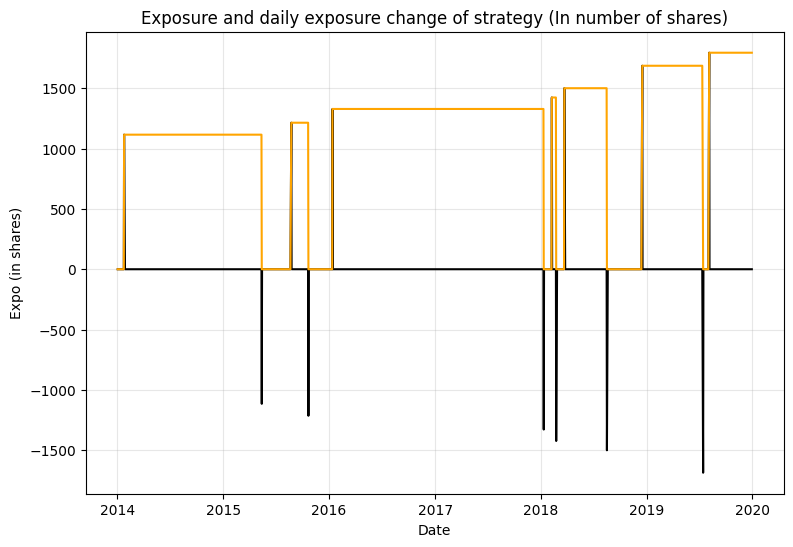

In [65]:
turnover_units = pd.DataFrame(turnover_units, index=data.index)
exposure_units = pd.DataFrame(exposure_units, index=data.index)

plt.plot(turnover_units, label="Daily change in exposure (in shares)", color="0")
plt.plot(exposure_units, label="Exposure", color="orange")
plt.xlabel("Date")
plt.ylabel("Expo (in shares)")
plt.title("Exposure and daily exposure change of strategy (In number of shares)")
plt.grid(alpha=0.3)
plt.show()


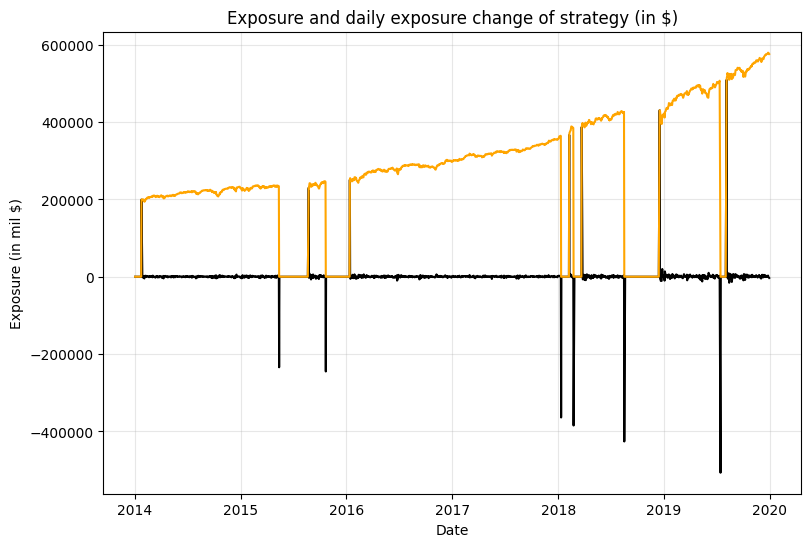

In [66]:
turnover_dollar = pd.DataFrame(turnover_dollar, index=data.index)
exposure = pd.DataFrame(exposure, index=data.index)

plt.plot(turnover_dollar, label="Daily change in exposure (in $)", color="0")
plt.plot(exposure, label="Exposure", color="orange")
plt.xlabel("Date")
plt.ylabel("Exposure (in mil $)")
plt.title("Exposure and daily exposure change of strategy (in $)")
plt.grid(alpha=0.3)
plt.show()


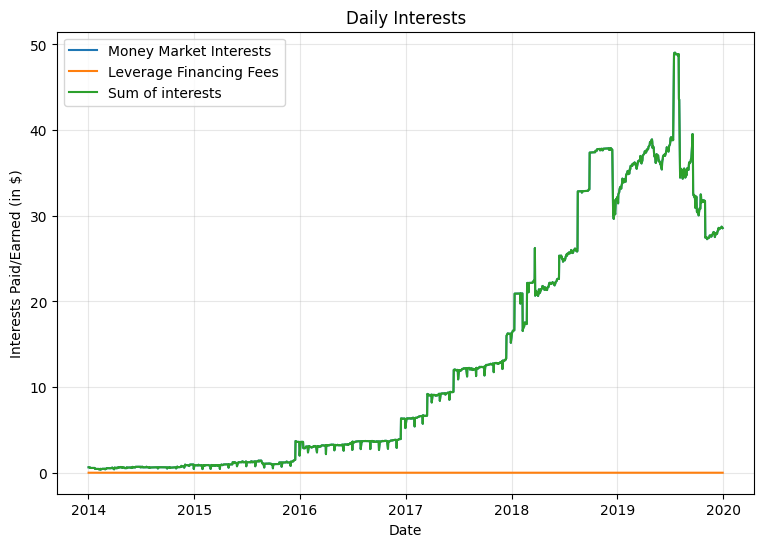

In [67]:
accumulated_interests = pd.DataFrame(accumulated_interests, index=data.index)
leverage_financing_dollar = pd.DataFrame(leverage_financing_dollar, index=data.index)

plt.plot(data.index, accumulated_interests, label="Money Market Interests")
plt.title("Daily Interests")
plt.plot(data.index,leverage_financing_dollar, label="Leverage Financing Fees")
plt.plot(data.index, leverage_financing_dollar+accumulated_interests, label="Sum of interests")
plt.legend(loc="best")
plt.xlabel("Date")
plt.ylabel("Interests Paid/Earned (in $)")
plt.grid(alpha=0.3)
plt.show()

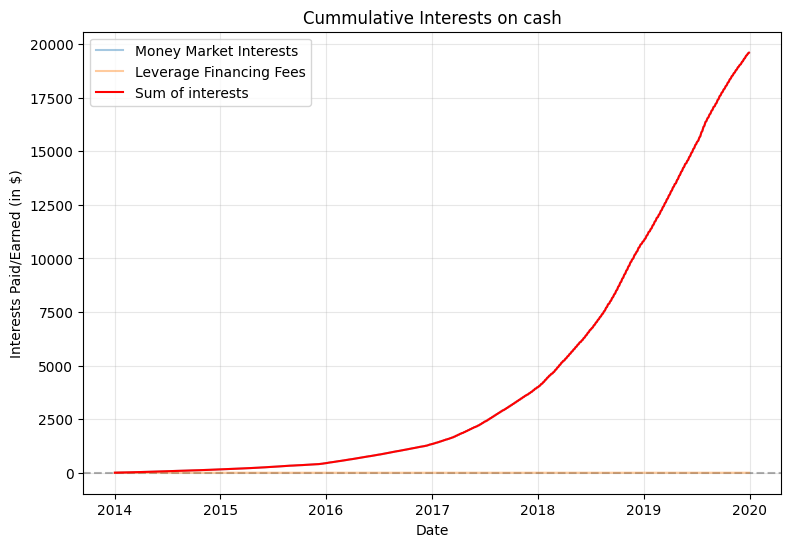

In [68]:
acc_int = accumulated_interests.cumsum()
lev_finn = leverage_financing_dollar.cumsum()

plt.plot(acc_int, label="Money Market Interests", alpha=0.4)
plt.title("Cummulative Interests on cash")
plt.axhline(0, linestyle="--", color="0", alpha=0.3)
plt.plot(lev_finn, label="Leverage Financing Fees", alpha=0.4)
plt.plot(lev_finn+acc_int, label="Sum of interests", color="r")
plt.legend(loc="best")
plt.xlabel("Date")
plt.ylabel("Interests Paid/Earned (in $)")
plt.grid(alpha=0.3)
plt.show()

The maximum value of posted margin to book ratio was: 19.99%



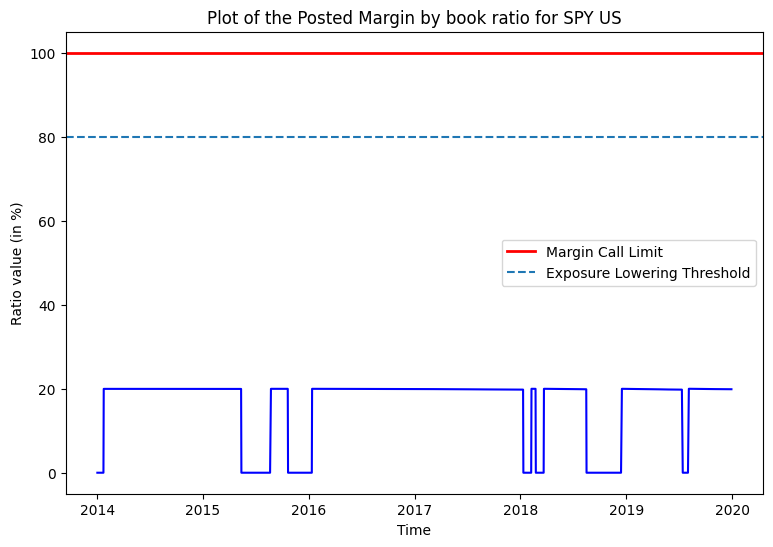

In [69]:
total_portfolio_value = pd.DataFrame(total_porfolio_value, index=data.index)
posted_margin = pd.DataFrame(posted_margin, index=data.index)

margin_req_by_book_value = 100*posted_margin/total_portfolio_value

print(f"The maximum value of posted margin to book ratio was: {round(margin_req_by_book_value.max()[0], 2)}%")
print("")

plt.plot(margin_req_by_book_value, color="b")
plt.axhline(100, label="Margin Call Limit", color="red", linewidth="2")
plt.axhline(100*degross_ratio, label="Exposure Lowering Threshold", linestyle="--")
plt.legend(loc="best")
plt.xlabel("Time")
plt.title(f"Plot of the Posted Margin by book ratio for {ticker} US")
plt.ylabel("Ratio value (in %)")
plt.savefig("VWAP strategy1.png", dpi=150)
plt.show()

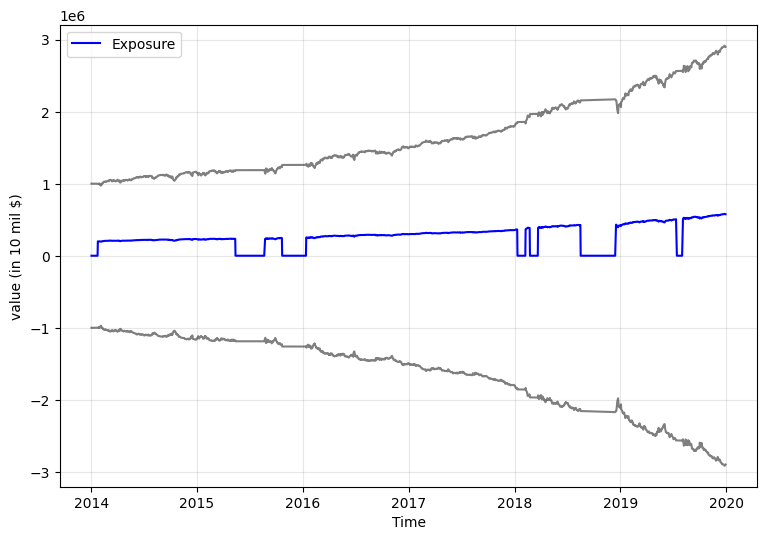

In [70]:
plt.plot(exposure, color="Blue", label = "Exposure")
plt.plot(-5*total_portfolio_value, color="0", alpha=0.5)
plt.plot(5*total_portfolio_value, color="0", alpha=0.5)
plt.legend()
plt.xlabel("Time")
plt.ylabel("value (in 10 mil $)")
plt.grid(alpha=0.3)
plt.show()

In [71]:
# sharpe, calmar, sortino and max drawdown calculation

excess_return = []
for i in range(len(pnl)):
    excess_return.append(pnl[i]-data["Risk Free Rate"][i])
excess_return = pd.DataFrame(excess_return, index=data.index)

sharpe_ratio = ep.sharpe_ratio(excess_return)[0]
#timeseries.sharpe_ratio(excess_return)[0]
max_drawdown = 100*ep.max_drawdown(excess_return)[0]
sortino_ratio = ep.sortino_ratio(excess_return)[0]
calmar_ratio = ((excess_return.mean()[0]+1)**(252)-1)/(-max_drawdown/100)  # EP function crashes 

print(f"Sharpe: {round(sharpe_ratio,2)}") 
print(f"Max Drawdown: {round(max_drawdown, 2)}%")
print(f"Sortino Ratio: {round(sortino_ratio, 2)}")
print(f"Calmar Ratio: {round(calmar_ratio, 2)}")


Sharpe: 1.58
Max Drawdown: -8.9%
Sortino Ratio: 2.38
Calmar Ratio: 2.14


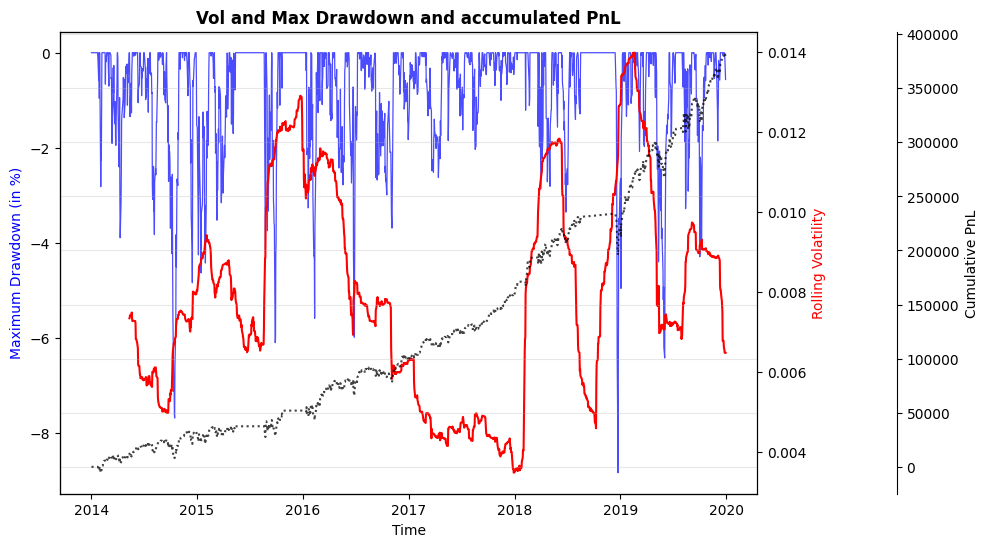

In [72]:
rolling_volatility = data["return"].rolling(window=90).std()
to_calc_max_dd = pd.Series(total_portfolio_value[0])
max_data = to_calc_max_dd.rolling(window=30, min_periods=1).max()
drawdown = to_calc_max_dd/max_data - 1
monthly_drawdown = drawdown.rolling(window=1, min_periods=1).min()
cash_pnl = pd.DataFrame(cash_pnl, index=data.index)


# Create a figure with two y-axes
fig, ax1 = plt.subplots()
color = 'blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Maximum Drawdown (in %)', color=color)
ax1.plot(100*monthly_drawdown, color=color, linewidth=0.9, alpha=0.7)

ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('Rolling Volatility', color=color)
ax2.plot(rolling_volatility, color=color, label="90d Volatility")
ax2.tick_params(axis='y')

# Create a third y-axis for the daily pnl
ax3 = ax1.twinx()

# Plot the daily pnl on ax3
color = '0'
ax3.plot(data.index, cash_pnl.cumsum(), color=color, linestyle=":", label="Cumulative PnL", alpha=0.75)
ax3.set_ylabel('Cumulative PnL', color=color)
ax3.spines['right'].set_position(('axes', 1.2))
plt.grid(alpha=0.3)
plt.title("Vol and Max Drawdown and accumulated PnL", fontweight="bold")
plt.savefig("Vol_maxDD_and.png")
plt.show()

<h3>Trading Strategy 3: Long Short VWAP trading strategy</h3>

Going short only if strong signal is triggered

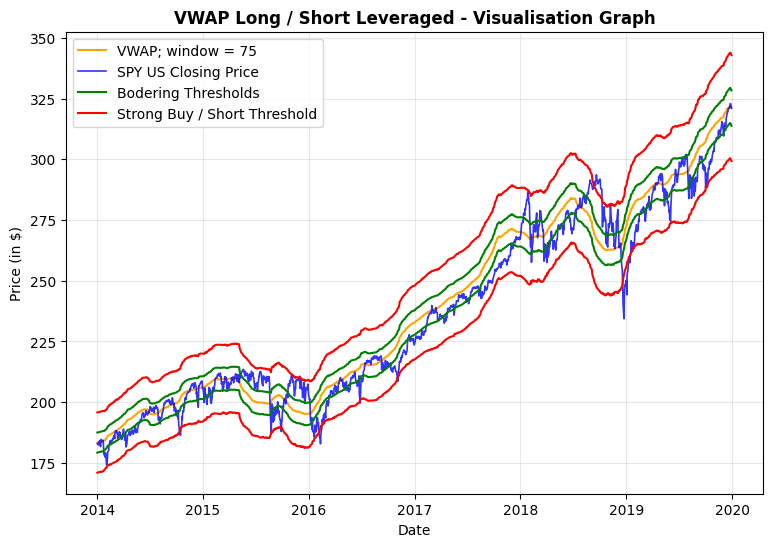

In [80]:
alpha = 0.0003

t_plus = data["VWAP"] + alpha*data["Open"]*VWAP_window
t_minus = data["VWAP"] - alpha*data["Open"]*VWAP_window
t_minus_2 = data["VWAP"] - 3*alpha*data["Open"]*VWAP_window
t_plus_2 = data["VWAP"] + 3*alpha*data["Open"]*VWAP_window

plt.style.use('default')
plt.rcParams["figure.figsize"] = (9,6)

label = "VWAP; window = " + str(VWAP_window)
plt.plot(data["VWAP"], label=label, color="orange")
plt.plot(data["Close"], label="SPY US Closing Price", color="blue",alpha=0.8, linewidth=1.2)
plt.plot(t_minus, label="Bodering Thresholds", color="green")
plt.plot(t_minus_2, label="Strong Buy / Short Threshold", color="red")
plt.plot(t_plus, color="green")
plt.plot(t_plus_2, color="red")

plt.grid(alpha=0.3)
plt.legend(loc="upper left")
plt.title("VWAP Long / Short Leveraged - Visualisation Graph", fontweight="bold")
plt.ylabel("Price (in $)")
plt.xlabel("Date")
plt.savefig("VWAP_LongShort_visu.png", dpi=200)
plt.show()

2014-01-24 00:00:00
Bought 1117 SPY at $179.06

Strong Buy:
2014-10-13 00:00:00
Bought 2234 SPY at $188.42

2015-05-14 00:00:00
Sold 3351 SPY at $212.44

2015-08-24 00:00:00
Bought 1534 SPY at $195.43

Strong Buy:
2015-09-28 00:00:00
Bought 2973 SPY at $188.27

2015-10-22 00:00:00
Sold 4507 SPY at $207.25

2016-01-13 00:00:00
Bought 1935 SPY at $189.550003

Strong Buy:
2016-06-27 00:00:00
Bought 3863 SPY at $201.479996

2018-01-11 00:00:00
Sold 5798 SPY at $276.42

Short
2018-01-12 00:00:00
Sold 8832 SPY at $279.35

Cover shorts
2018-02-08 00:00:00
Bought 8832 SPY at $260.8

2018-02-09 00:00:00
Bought 3765 SPY at $263.83

2018-02-23 00:00:00
Sold 3765 SPY at $275.93

Short
2018-02-26 00:00:00
Sold 11129 SPY at $278.11

Cover shorts
2018-03-23 00:00:00
Bought 11129 SPY at $262.13

2018-03-27 00:00:00
Bought 4653 SPY at $260.75

2018-08-17 00:00:00
Sold 4653 SPY at $285.57

Short
2018-08-20 00:00:00
Sold 14025 SPY at $286.25

Cover shorts
2018-12-17 00:00:00
Bought 14025 SPY at $257.2

2

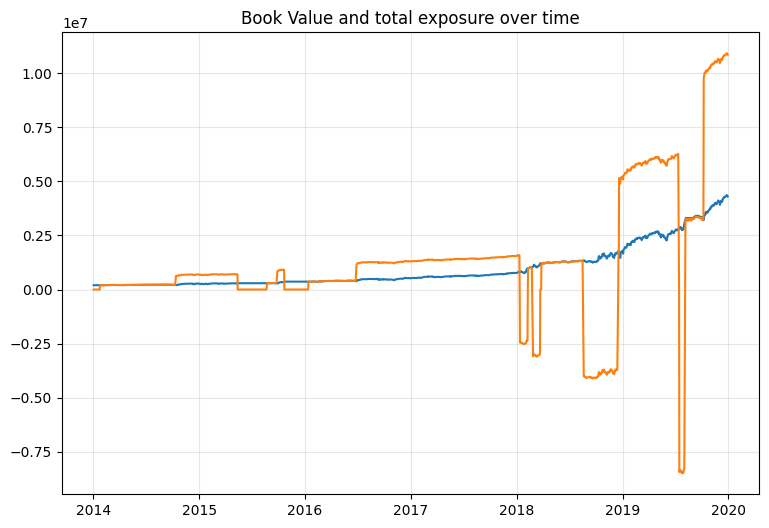

In [81]:
# Portfolio initiation
# Long only strategy

portfolio = {
            "cash": 200000, # Tracks debt owed to Prime Broker, is impacted by leverage financing and by interests earned in money market
            "money_market": 200000, # cannot be negative or margin called
            "SPY": 0, # asset owned
            "posted_margin": 0
            }

turnover_dollar, exposure_units, turnover_units, cash_pnl, exposure, leverage_financing_dollar, short_financing_dollars, total_porfolio_value, cash, pnl, money_market, posted_margin, accumulated_interests  = [], [], [], [], [], [], [], [], [], [], [], [], []

can_strong_buy = True
can_buy = True
can_strong_sell = True
can_short = True

degross_ratio = 0.80 # Threshold at which it is needed to degross
sell_to_in_degross = 0.60 # Where to aim degrossing the book

data = data.sort_index() # to iterate chronologically
t_minus = t_minus.sort_index()
t_minus_2 = t_minus_2.sort_index()
t_plus = t_plus.sort_index()

for i in range(len(data)):
    
    if data["Close"][i] > t_plus_2[i] and portfolio['SPY'] == 0 and can_strong_sell: # Short levered
        amount = int((max_exposure)*(value_portfolio(data["Close"][i])/data["Close"][i])-1) # 3x leverage buy
        print("Short")
        print(data.index[i])
        sell(amount, data["Open"][i+1]) # Sell at next day open 
        print("")
        can_strong_sell = False
        can_strong_buy = True
        can_buy = True
    
    if data["Close"][i] > t_plus[i] and portfolio['SPY'] > 0:
        print(data.index[i])
        sell(portfolio['SPY'], data["Open"][i+1]) # Sell at next day open 
        print("")
        can_strong_buy = True
        can_buy = True
        can_strong_sell = True
    
    elif data["Close"][i] < t_minus[i] and portfolio['SPY'] == 0 and can_buy: # long no lev
        amount = int((portfolio['cash']/data["Close"][i])-1)
        print(data.index[i])
        buy(amount, data["Open"][i+1]) # Buy at next day open
        print("")

        
    elif data["Close"][i] < t_minus[i] and portfolio['SPY'] < 0 : # Cover shorts and go long 
        print("Cover shorts")
        print(data.index[i])
        buy(-portfolio['SPY'], data["Open"][i+1]) # Buy at next day open
        print("")

        
    elif data["Close"][i] < t_minus_2[i] and not(data["Close"][i-1] < t_minus_2[i]) and can_strong_buy: # Strong  Buys
        amount = int((max_exposure-1)*(value_portfolio(data["Close"][i])/data["Close"][i])-1) # Max leverage buy
        print("Strong Buy:")
        print(data.index[i])
        buy(amount, data["Open"][i+1])
        print("")
        can_strong_buy = False
    
    total_porfolio_value.append(value_portfolio(data["Close"][i]))
    exposure.append(portfolio["SPY"]*data["Close"][i])
    exposure_units.append(portfolio["SPY"])
    leverage.append(portfolio["SPY"]*data["Close"][i]/value_portfolio(data["Close"][i]))
    
    if portfolio["cash"] < 0: # If im short cash, I pay interests on financing. 
        portfolio["cash"] = portfolio["cash"] * (1 + data["Risk Free Rate"][i])
        leverage_financing_dollar.append(portfolio["cash"]*(data["Risk Free Rate"][i]))
    else:
        leverage_financing_dollar.append(0)
    if i == 0:
        pnl.append(0)
        cash_pnl.append(0)
        turnover_dollar.append(0)
        turnover_units.append(0)
    else:
        pnl.append((total_porfolio_value[i] - total_porfolio_value[i-1])/total_porfolio_value[i-1])
        cash_pnl.append(total_porfolio_value[i] - total_porfolio_value[i-1])
        turnover_dollar.append(exposure[i]-exposure[i-1])
        turnover_units.append((exposure_units[i]-exposure_units[i-1]))
    
    if portfolio["SPY"] < 0: # If Im short stock, I pay short financing  
        portfolio["cash"] = portfolio["cash"] - (exposure[-1]*(data["Risk Free Rate"][i]))
        short_financing_dollars.append(exposure[-1]*(data["Risk Free Rate"][i])) # I pay 100% of my short expo on fees 
    else:
        short_financing_dollars.append(0)
        
    # Money Market/ Value:
    
    portfolio["posted_margin"] = np.abs(exposure[i]) / margin_call_max_lev
    posted_margin.append(portfolio["posted_margin"])
    
    portfolio["money_market"] = total_porfolio_value[i] - posted_margin[i]
    money_market.append(portfolio["money_market"])
    
    # Money market account value's impact on cash:
    
    accumulated_interests.append(portfolio["money_market"]*(data["Risk Free Rate"][i]))
    portfolio["cash"] = portfolio["cash"] + (portfolio["money_market"]*(data["Risk Free Rate"][i]))
    cash.append(portfolio["cash"])
    ratio = portfolio["posted_margin"] / total_porfolio_value[i]
    
    # Different from Long only!!!!
    if ratio > degross_ratio:
        if portfolio["SPY"] > 0:
            degross_amount = int((exposure[i]-(sell_to_in_degross*total_porfolio_value[i]*margin_call_max_lev))/data["Close"][i])-int(1)
            can_buy = False
            print("!DEGROSS ALERT! - Gonna sell")
            print(data.index[i])
            sell(degross_amount, data["Open"][i+1])
            print("")

        else:
            degross_amount = int((np.abs(exposure[i])-(sell_to_in_degross*total_porfolio_value[i]*margin_call_max_lev))/data["Close"][i])-int(1)
            can_buy = False
            print("!DEGROSS ALERT! - gonna buy")
            print(data.index[i])
            buy(degross_amount, data["Open"][i+1])
            print("")

    
print(portfolio)
print(f"Portfolio Value at end: {round(total_porfolio_value[-1], 2)}")
# check annualized returns

returns_strat1 = ((total_porfolio_value[-1]-total_porfolio_value[0])/total_porfolio_value[0])
print(f"Returns of strat over 6 years is: {round(100*returns_strat1, 2)}% or {round((np.power(1+returns_strat1, 1/6)-1)*100, 2)}% annualized returns\n")
print(f"Sum of leverage financing over trading period: ${-round(sum(leverage_financing_dollar), 2)}")
print(f"Sum of short financing over trading period: ${-round(sum(short_financing_dollars), 2)}")
print(f"Sum of interests earned over trading period: ${round(sum(accumulated_interests), 2)}")
print(f"Turnover of strategy: ${round(total_porfolio_value[-1]-total_porfolio_value[0], 2)} or {int(round(total_porfolio_value[-1]-total_porfolio_value[0], 2)/data['Close'][-1])} units of {ticker} (final close price)")


plt.plot(data.index, total_porfolio_value)
plt.plot(data.index, exposure)
plt.title("Book Value and total exposure over time")
plt.grid(alpha=0.3)
plt.show()


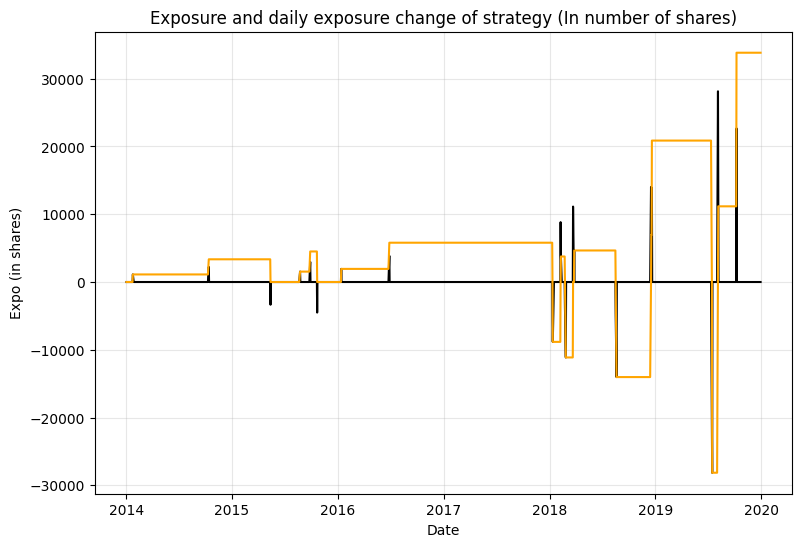

In [82]:
turnover_units = pd.DataFrame(turnover_units, index=data.index)
exposure_units = pd.DataFrame(exposure_units, index=data.index)

plt.plot(turnover_units, label="Daily change in exposure (in $)", color="0")
plt.plot(exposure_units, label="Exposure", color="orange")
plt.xlabel("Date")
plt.ylabel("Expo (in shares)")
plt.title("Exposure and daily exposure change of strategy (In number of shares)")
plt.grid(alpha=0.3)
plt.show()

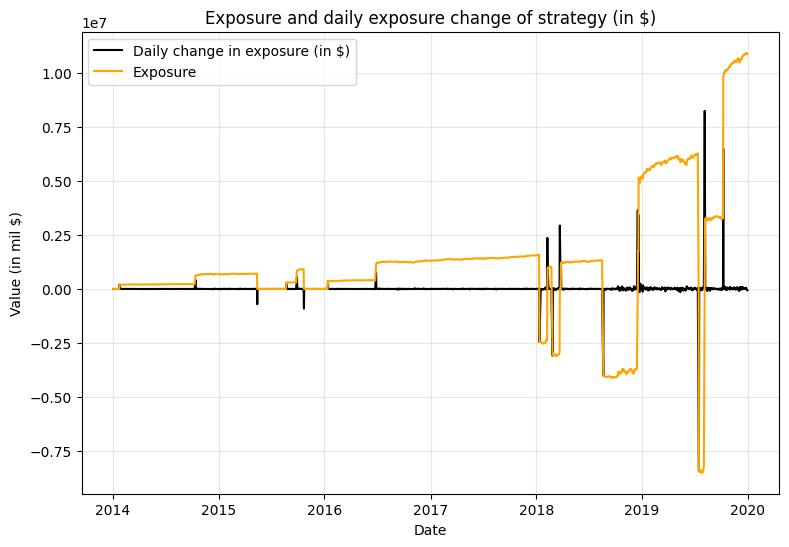

In [83]:
turnover_dollar = pd.DataFrame(turnover_dollar, index=data.index)
exposure = pd.DataFrame(exposure, index=data.index)
tur2 = turnover_dollar.cumsum()

plt.plot(turnover_dollar, label="Daily change in exposure (in $)", color="0")
plt.plot(exposure, label="Exposure", color="orange")
plt.xlabel("Date")
plt.ylabel("Value (in mil $)")
plt.title("Exposure and daily exposure change of strategy (in $)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

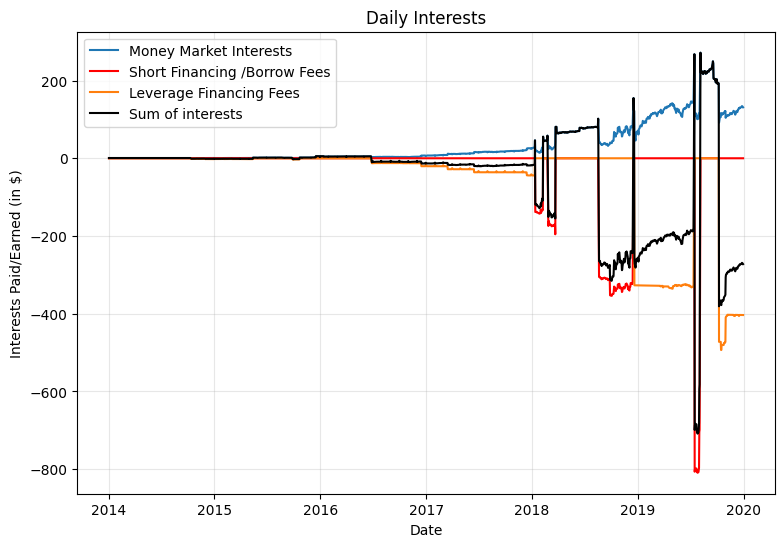

In [84]:
accumulated_interests = pd.DataFrame(accumulated_interests, index=data.index)
leverage_financing_dollar = pd.DataFrame(leverage_financing_dollar, index=data.index)
short_financing_dollars = pd.DataFrame(short_financing_dollars, index=data.index)

plt.plot(data.index, accumulated_interests, label="Money Market Interests")
plt.title("Daily Interests")
plt.plot(short_financing_dollars, label="Short Financing /Borrow Fees", color="red")
plt.plot(data.index,leverage_financing_dollar, label="Leverage Financing Fees")
plt.plot(data.index, leverage_financing_dollar+accumulated_interests+short_financing_dollars, label="Sum of interests", color="0")
plt.legend(loc="best")
plt.xlabel("Date")
plt.ylabel("Interests Paid/Earned (in $)")
plt.grid(alpha=0.3)
plt.show()


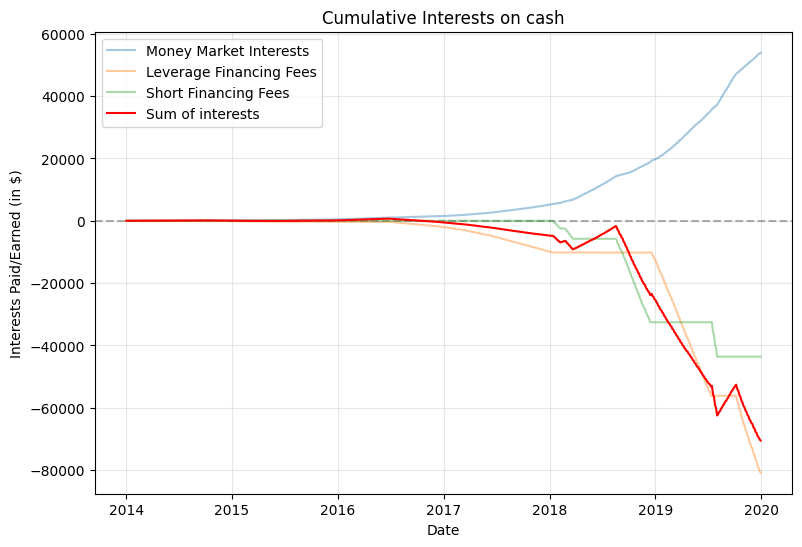

In [85]:
acc_int = accumulated_interests.cumsum()
lev_finn = leverage_financing_dollar.cumsum()
shor_sell_fee = short_financing_dollars.cumsum()

plt.plot(acc_int, label="Money Market Interests", alpha=0.4)
plt.title("Cumulative Interests on cash")
plt.axhline(0, linestyle="--", color="0", alpha=0.3)
plt.plot(lev_finn, label="Leverage Financing Fees", alpha=0.4)
plt.plot(shor_sell_fee, label="Short Financing Fees", alpha=0.4)
plt.plot(lev_finn+acc_int+shor_sell_fee, label="Sum of interests", color="r")
plt.legend(loc="best")
plt.xlabel("Date")
plt.ylabel("Interests Paid/Earned (in $)")
plt.grid(alpha=0.3)
plt.show()

The maximum value of posted margin to book ratio was: 67.12%



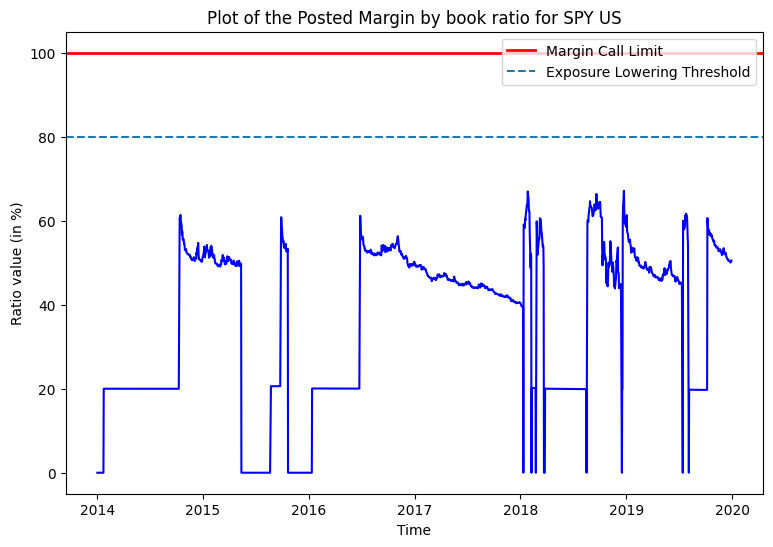

In [86]:
total_portfolio_value = pd.DataFrame(total_porfolio_value, index=data.index)
posted_margin = pd.DataFrame(posted_margin, index=data.index)

margin_req_by_book_value = 100*posted_margin/total_portfolio_value

print(f"The maximum value of posted margin to book ratio was: {round(margin_req_by_book_value.max()[0], 2)}%")
print("")

plt.plot(margin_req_by_book_value, color="b")
plt.axhline(100, label="Margin Call Limit", color="red", linewidth="2")
plt.axhline(100*degross_ratio, label="Exposure Lowering Threshold", linestyle="--")
plt.legend(loc="best")
plt.xlabel("Time")
plt.title(f"Plot of the Posted Margin by book ratio for {ticker} US")
plt.ylabel("Ratio value (in %)")
plt.savefig("VWAP strategy1.png", dpi=150)
plt.show()

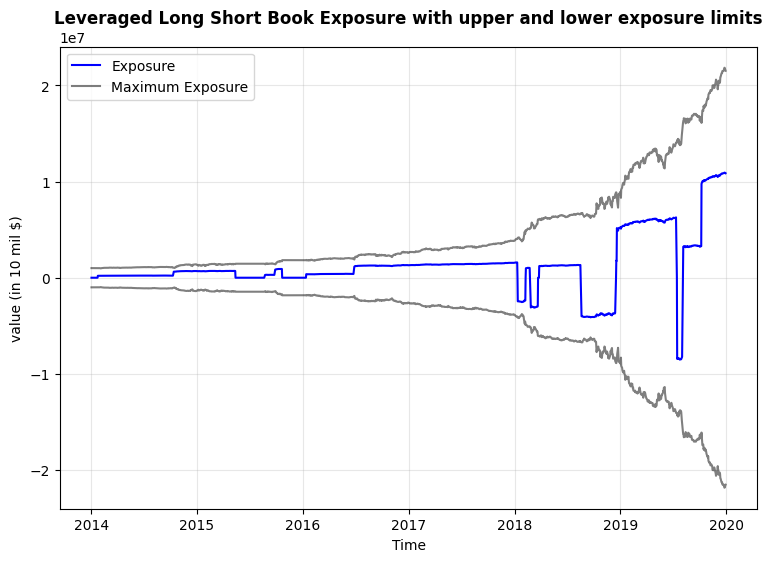

In [87]:
plt.plot(exposure, color="Blue", label = "Exposure")
plt.plot(-5*total_portfolio_value, color="0", alpha=0.5)
plt.plot(5*total_portfolio_value, color="0", alpha=0.5, label="Maximum Exposure")
plt.legend()
plt.xlabel("Time")
plt.ylabel("value (in 10 mil $)")
plt.grid(alpha=0.3)
plt.title("Leveraged Long Short Book Exposure with upper and lower exposure limits", fontweight="bold")
plt.savefig("leveraged_ls.png", dpi=200)
plt.show()

In [89]:
# sharpe, calmar, sortino and max drawdown calculation

excess_return = []
for i in range(len(pnl)):
    excess_return.append(pnl[i]-data["Risk Free Rate"][i])
excess_return = pd.DataFrame(excess_return, index=data.index)

sharpe_ratio = ep.sharpe_ratio(excess_return)[0]
#timeseries.sharpe_ratio(excess_return)[0]
max_drawdown = 100*ep.max_drawdown(excess_return)[0]
sortino_ratio = ep.sortino_ratio(excess_return)[0]
calmar_ratio = ((excess_return.mean()[0]+1)**(252)-1)/(-max_drawdown/100)  # EP function crashes 

print(f"Sharpe: {round(sharpe_ratio,2)}") 
print(f"Max Drawdown: {round(max_drawdown, 2)}%")
print(f"Sortino Ratio: {round(sortino_ratio, 2)}")
print(f"Calmar Ratio: {round(calmar_ratio, 2)}")

Sharpe: 2.07
Max Drawdown: -17.93%
Sortino Ratio: 3.57
Calmar Ratio: 3.96


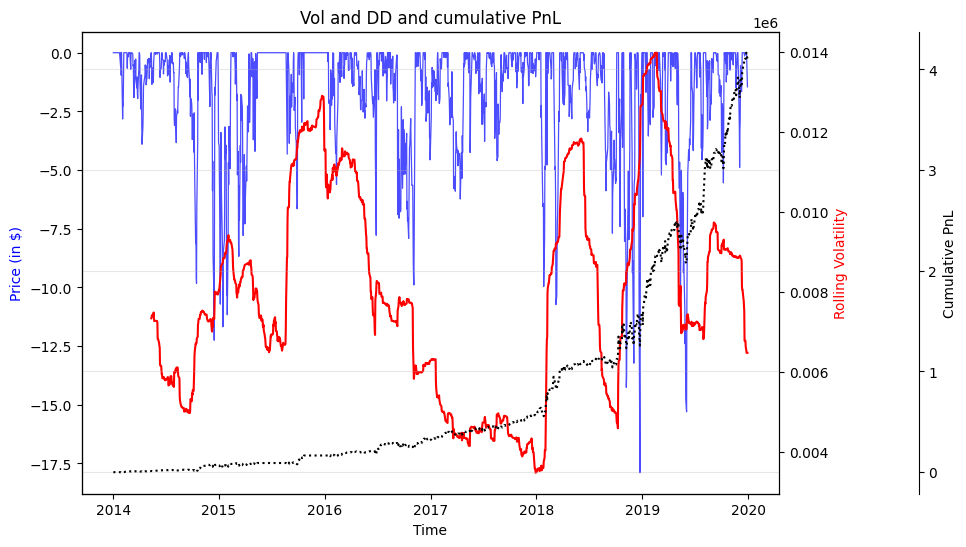

In [91]:
rolling_volatility = data["return"].rolling(window=90).std()
to_calc_max_dd = pd.Series(total_portfolio_value[0])
max_data = to_calc_max_dd.rolling(window=30, min_periods=1).max()
drawdown = to_calc_max_dd/max_data - 1
monthly_drawdown = drawdown.rolling(window=1, min_periods=1).min()
cash_pnl = pd.DataFrame(cash_pnl, index=data.index)


# Create a figure with two y-axes
fig, ax1 = plt.subplots()
color = 'blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Price (in $)', color=color)
ax1.plot(100*monthly_drawdown, color=color, linewidth=0.9, alpha=0.7)

ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('Rolling Volatility', color=color)
ax2.plot(rolling_volatility, color=color, label="90d Volatility")
ax2.tick_params(axis='y')

# Create a third y-axis for the daily pnl
ax3 = ax1.twinx()

# Plot the daily pnl on ax3
color = '0'
ax3.plot(data.index, cash_pnl.cumsum(), color=color, linestyle=":", label="Cumulative PnL")
ax3.set_ylabel('Cumulative PnL', color=color)
ax3.spines['right'].set_position(('axes', 1.2))

plt.grid(alpha=0.3)
plt.title("Vol and DD and cumulative PnL")
plt.show()

2014-01-02 00:00:00
Bought 1090 SPY at $183.23

{'cash': 13708.530901842083, 'money_market': 293672.2277291048, 'SPY': 1090, 'posted_margin': 69995.44}
Portfolio Value at end: 363667.67
Returns of strat over 6 years is: 82.14% or 10.51% annualized returns

Sum of leverage financing over trading period: $0
Sum of short financing over trading period: $0
Sum of interests earned over trading period: $13429.23
Turnover of strategy: $164005.57 or 510 units of SPY (final close price)


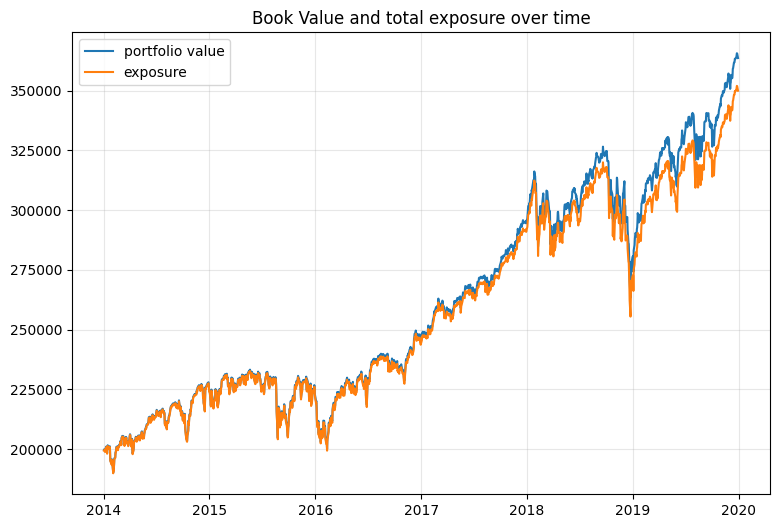

In [92]:
# BENCMARKKKKKK


# Portfolio initiation
# Long only strategy

portfolio = {
            "cash": 200000, # Tracks debt owed to Prime Broker, is impacted by leverage financing and by interests earned in money market
            "money_market": 200000, # cannot be negative or margin called
            "SPY": 0, # asset owned
            "posted_margin": 0
            }

turnover_dollar, exposure_units, turnover_units, cash_pnl, exposure, leverage_financing_dollar, short_financing_dollars, total_porfolio_value, cash, pnl, money_market, posted_margin, accumulated_interests  = [], [], [], [], [], [], [], [], [], [], [], [], []

can_strong_buy = True
can_buy = True
can_strong_sell = True
can_short = True

degross_ratio = 0.80 # Threshold at which it is needed to degross
sell_to_in_degross = 0.60 # Where to aim degrossing the book

data = data.sort_index() # to iterate chronologically
t_minus = t_minus.sort_index()
t_minus_2 = t_minus_2.sort_index()
t_plus = t_plus.sort_index()

for i in range(len(data)):
    
    if i==0: # long no lev
        amount = int((portfolio['cash']/data["Open"][i+1])-1)
        print(data.index[i])
        buy(amount, data["Open"][i+1]) # Buy at next day open
        print("")
    
    total_porfolio_value.append(value_portfolio(data["Close"][i]))
    exposure.append(portfolio["SPY"]*data["Close"][i])
    exposure_units.append(portfolio["SPY"])
    leverage.append(portfolio["SPY"]*data["Close"][i]/value_portfolio(data["Close"][i]))
    
    if portfolio["cash"] < 0: # If im short cash, I pay interests on financing. 
        portfolio["cash"] = portfolio["cash"] * (1 + data["Risk Free Rate"][i])
        leverage_financing_dollar.append(portfolio["cash"]*(data["Risk Free Rate"][i]))
    else:
        leverage_financing_dollar.append(0)
    if i == 0:
        pnl.append(0)
        cash_pnl.append(0)
        turnover_dollar.append(0)
        turnover_units.append(0)
    else:
        pnl.append((total_porfolio_value[i] - total_porfolio_value[i-1])/total_porfolio_value[i-1])
        cash_pnl.append(total_porfolio_value[i] - total_porfolio_value[i-1])
        turnover_dollar.append(exposure[i]-exposure[i-1])
        turnover_units.append((exposure_units[i]-exposure_units[i-1]))
    
    if portfolio["SPY"] < 0: # If Im short stock, I pay short financing  
        portfolio["cash"] = portfolio["cash"] - (exposure[-1]*(data["Risk Free Rate"][i]))
        short_financing_dollars.append(exposure[-1]*(data["Risk Free Rate"][i])) # I pay 100% of my short expo on fees 
    else:
        short_financing_dollars.append(0)
        
    # Money Market/ Value:
    
    portfolio["posted_margin"] = np.abs(exposure[i]) / margin_call_max_lev
    posted_margin.append(portfolio["posted_margin"])
    
    portfolio["money_market"] = total_porfolio_value[i] - posted_margin[i]
    money_market.append(portfolio["money_market"])
    
    # Money market account value's impact on cash:
    
    accumulated_interests.append(portfolio["money_market"]*(data["Risk Free Rate"][i]))
    portfolio["cash"] = portfolio["cash"] + (portfolio["money_market"]*(data["Risk Free Rate"][i]))
    cash.append(portfolio["cash"])
    ratio = portfolio["posted_margin"] / total_porfolio_value[i]
    

print(portfolio)
print(f"Portfolio Value at end: {round(total_porfolio_value[-1], 2)}")
# check annualized returns

returns_strat1 = ((total_porfolio_value[-1]-total_porfolio_value[0])/total_porfolio_value[0])
print(f"Returns of strat over 6 years is: {round(100*returns_strat1, 2)}% or {round((np.power(1+returns_strat1, 1/6)-1)*100, 2)}% annualized returns\n")
print(f"Sum of leverage financing over trading period: ${-round(sum(leverage_financing_dollar), 2)}")
print(f"Sum of short financing over trading period: ${-round(sum(short_financing_dollars), 2)}")
print(f"Sum of interests earned over trading period: ${round(sum(accumulated_interests), 2)}")
print(f"Turnover of strategy: ${round(total_porfolio_value[-1]-total_porfolio_value[0], 2)} or {int(round(total_porfolio_value[-1]-total_porfolio_value[0], 2)/data['Close'][-1])} units of {ticker} (final close price)")


plt.plot(data.index, total_porfolio_value, label="portfolio value")
plt.plot(data.index, exposure, label="exposure")
plt.title("Book Value and total exposure over time")
plt.grid(alpha=0.3)
plt.legend()
plt.show()



In [93]:

excess_return = []

for i in range(len(pnl)):
    excess_return.append(pnl[i]-data["Risk Free Rate"][i])
excess_return = pd.DataFrame(excess_return, index=data.index)

sharpe_ratio = ep.sharpe_ratio(excess_return)[0]
max_drawdown = 100*ep.max_drawdown(excess_return)[0]
sortino_ratio = ep.sortino_ratio(excess_return)[0]
calmar_ratio = ((excess_return.mean()[0]+1)**(252)-1)/(-max_drawdown/100)  # EP function crashes 

print(f"Sharpe: {round(sharpe_ratio,2)}") 
print(f"Max Drawdown: {round(max_drawdown, 2)}%")
print(f"Sortino Ratio: {round(sortino_ratio, 2)}")
print(f"Calmar Ratio: {round(calmar_ratio, 2)}")

Sharpe: 0.76
Max Drawdown: -19.81%
Sortino Ratio: 1.06
Calmar Ratio: 0.53


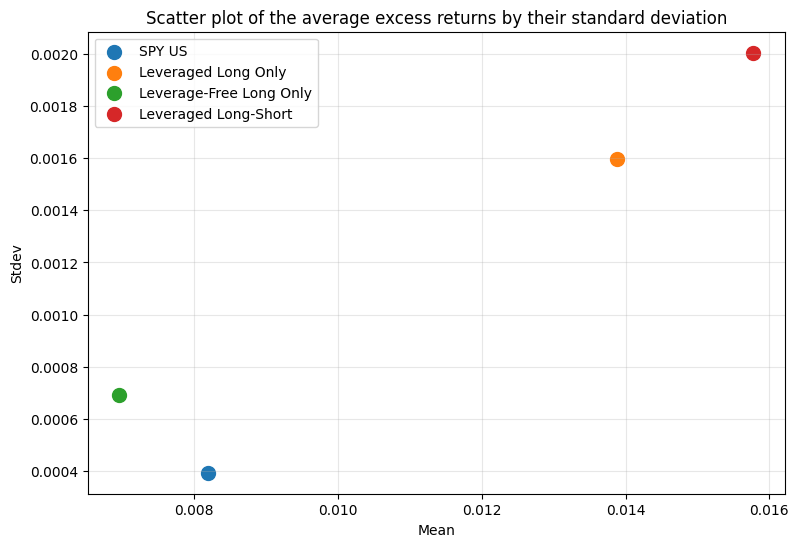

In [96]:
legend_scatter = ["SPDR", "Leveraged Long Only", "Leverage-Free Long Only", "Leveraged Long-Short"]
excess_ret_std_scatter = [0.008186946232809066, 0.013884807289849971, 0.006956717669659563, 0.01577888475165351]
excess_ret_mean_scatter = [0.00039391878330796655, 0.0015955678977316427, 0.0006923878127084184, 0.0020043655208647673]
for i in range(len(excess_ret_mean_scatter)):    
    plt.scatter(excess_ret_std_scatter[i], excess_ret_mean_scatter[i], s=100)

plt.legend(["SPY US", "Leveraged Long Only", "Leverage-Free Long Only", "Leveraged Long-Short"])
plt.xlabel("Mean")
plt.ylabel("Stdev")
plt.title("Scatter plot of the average excess returns by their standard deviation")
plt.grid(alpha=0.3)
plt.savefig("scatter_plot.png")
plt.show()